In [12]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calculate_metrics(true_values, pred_values):
    mse = round(mean_squared_error(true_values, pred_values),3)
    mae = round(mean_absolute_error(true_values, pred_values),3)
    r_score = round(r2_score(true_values, pred_values),3)

    return {"mse": mse,
            "mae": mae,
            "r_score": r_score,}


feature_names_remained = ['FPSA3',
 'GeomShapeIndex',
 'PNSA5',
 'PPSA5',
 'RPCS',
 'TASA',
 'cis/trans',
 'dipole_moment',
 'f_freedom',
 'f_to_fg',
 'identificator',
 'mol_weight',
 'nC',
 'nF',
 'nFHRing',
 'nHRing',
 'nN',
 'nO']
feature_names_remained.append('pKa')

In [2]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_pKa_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = ['dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=True,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=False,
                                           outliers_features_to_skip=unimportant_features_to_drop)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)
    # elif "angle" in feature_name or "distance" in feature_name:
    #     features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=True,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

merged_dataframe = pd.concat([train_df, test_df], axis=0)

True
183
['RPCS', 'PBF', 'mol_weight', 'dipole_moment', 'PPSA5', 'avg_atoms_in_cycle', 'nHRing', 'cis/trans', 'f_atom_fraction', 'dihedral_angle', 'FPSA3', 'distance_between_atoms_in_cycle_and_f_group', 'angle_X1X2R2', 'nF', 'angle_R1X1R2', 'nFAHRing', 'nAHRing', 'chirality', 'sasa', 'PNSA5', 'GeomShapeIndex', 'TASA', 'angle_R2X2R1', 'mol_num_cycles', 'naRing', 'nN', 'f_freedom', 'tpsa+f', 'nFRing', 'identificator', 'nO', 'distance_between_atoms_in_f_group_centers', 'angle_X2X1R1', 'nARing', 'nFARing', 'nC', 'nFHRing', 'f_to_fg', 'pKa', 'logP']
PBF outliers indexes: [40, 71, 127]
f_atom_fraction outliers indexes: [124]
FPSA3 outliers indexes: [40]
sasa outliers indexes: [127]
PNSA5 outliers indexes: [37, 38]
distance_between_atoms_in_f_group_centers outliers indexes: [35]
logP outliers indexes: [82, 83]
Remains rows:169, amount of features: 40
144 25


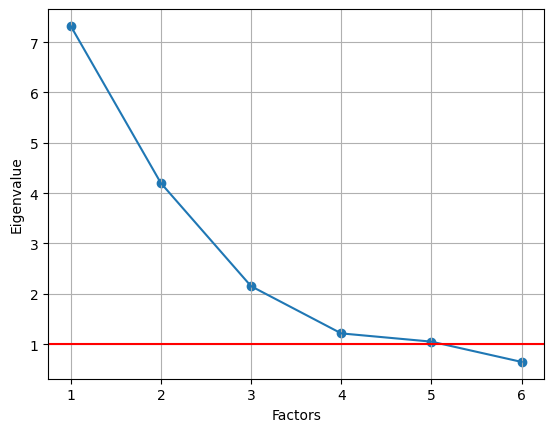

In [3]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# train_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\train_logP_v3.csv', index_col=0)
# test_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\test_logP_v3.csv', index_col=0)

features_to_analyse = []
for feature_name in merged_dataframe.columns:
    if len(merged_dataframe[feature_name].unique()) != 1:
        features_to_analyse.append(feature_name)
features_to_analyse.remove('fold_id')

fa = FactorAnalyzer(rotation=None)

try:
    df_features = merged_dataframe[feature_names_remained]
except:
    df_features = merged_dataframe[features_to_analyse]
# df_features = StandardScaler().fit_transform(df_features)
fa.fit(df_features)

ev, _ = fa.get_eigenvalues()
for index, en_value in enumerate(ev):
    if en_value < 1:
        break
index += 1

plt.scatter(range(1, index + 1), ev[:index])
plt.plot(range(1, index + 1), ev[:index])
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y = 1, color='r')
plt.grid()
plt.show()

In [4]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(df_features)
kmo_model

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.6665231009112262

In [5]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

df_for_bartlett_sphericity = StandardScaler().fit_transform(df_features)
chi_square_value, p_value = calculate_bartlett_sphericity(df_for_bartlett_sphericity)
print(f"statistics: {chi_square_value}, p-value: {p_value}")

statistics: 5319.814386492758, p-value: 0.0


In [6]:
from sklearn.preprocessing import StandardScaler

n_factors = 4

fa = FactorAnalyzer(n_factors=n_factors, rotation="varimax")

fa.fit(df_features)

fa_load = pd.DataFrame(fa.loadings_,index=df_features.columns)
fa_load.style.background_gradient(cmap="coolwarm")

,0,1,2,3
FPSA3,-0.766590,-0.401142,-0.433899,-0.044648
GeomShapeIndex,-0.474340,0.133129,-0.006286,-0.313420
PNSA5,0.638702,-0.622134,0.293426,0.075156
PPSA5,-0.831860,0.408581,0.072591,-0.121064
RPCS,0.213356,-0.636492,-0.081221,0.160109
TASA,0.576643,-0.058185,0.621788,-0.010976
cis/trans,-0.202659,0.075404,-0.217928,-0.066313
dipole_moment,-0.135135,0.708036,-0.068736,0.023945
f_freedom,0.003609,-0.735323,-0.246580,0.208702
f_to_fg,0.034630,0.735417,-0.135406,0.305192


Amount of feature: FPSA3: 168
R^2 score: 0.20817350962510212
{'mse': 0.0, 'mae': 0.005, 'r_score': 0.208}


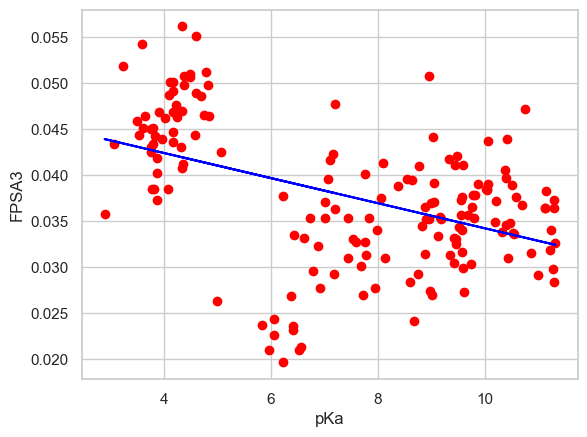

Amount of feature: PNSA5: 168
R^2 score: 0.6189248481442826
{'mse': 37.239, 'mae': 5.11, 'r_score': 0.619}


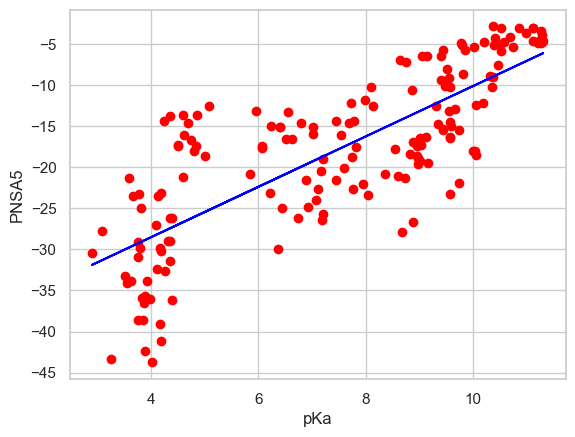

Amount of feature: PPSA5: 168
R^2 score: 0.829094265580821
{'mse': 0.928, 'mae': 0.736, 'r_score': 0.829}


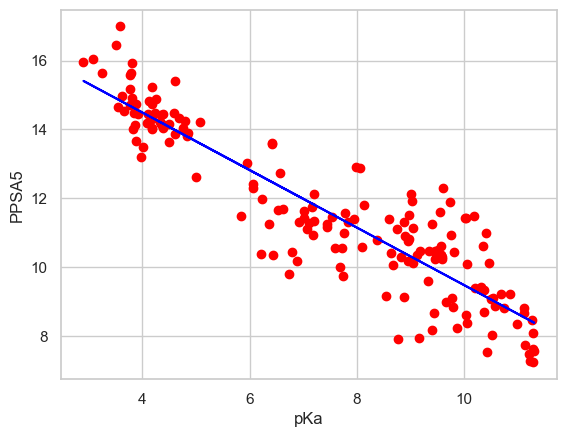

Amount of feature: TASA: 168
R^2 score: 0.2433531987095237
{'mse': 1793.273, 'mae': 33.317, 'r_score': 0.243}


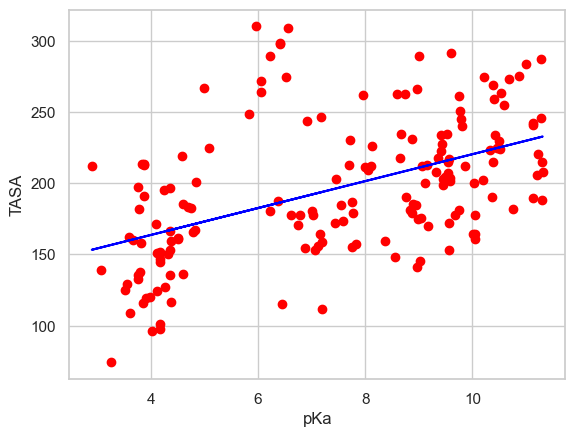

Amount of feature: identificator: 3
Kruskal for identificator: 104.97
P-value: 0.0000
There is a statistically significant difference between the groups


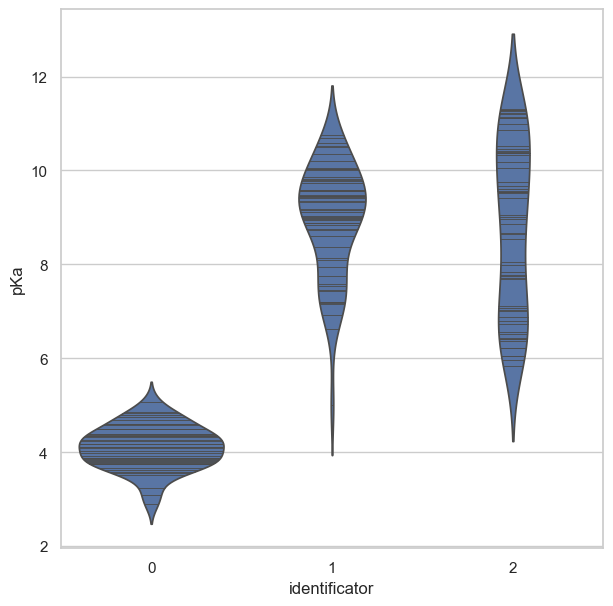

Amount of feature: nN: 2
Mann-Whitney U for nN: 1.00
P-value: 0.0000
There is a statistically significant difference between the groups


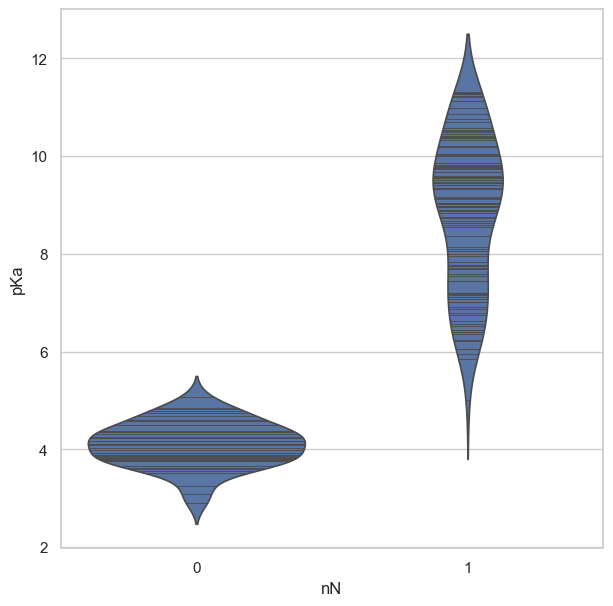

Amount of feature: nO: 4
Kruskal for nO: 105.16
P-value: 0.0000
There is a statistically significant difference between the groups


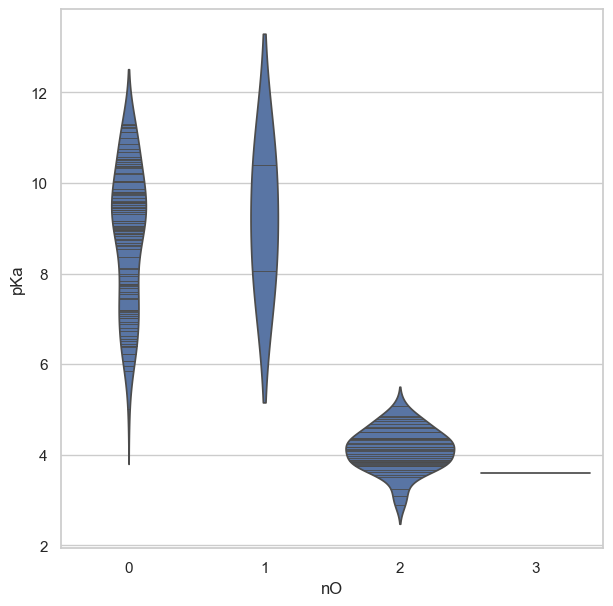

Amount of feature: PNSA5: 168
R^2 score: 0.6189248481442826
{'mse': 37.239, 'mae': 5.11, 'r_score': 0.619}


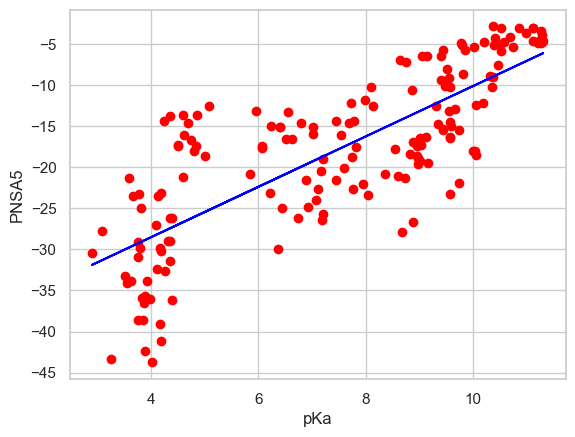

Amount of feature: RPCS: 150
R^2 score: 0.21961297292081638
{'mse': 1163.512, 'mae': 27.553, 'r_score': 0.22}


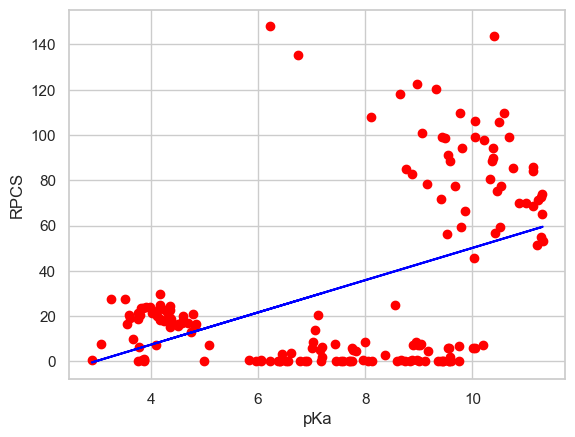

Amount of feature: dipole_moment: 168
R^2 score: 0.12262498467699993
{'mse': 0.019, 'mae': 0.119, 'r_score': 0.123}


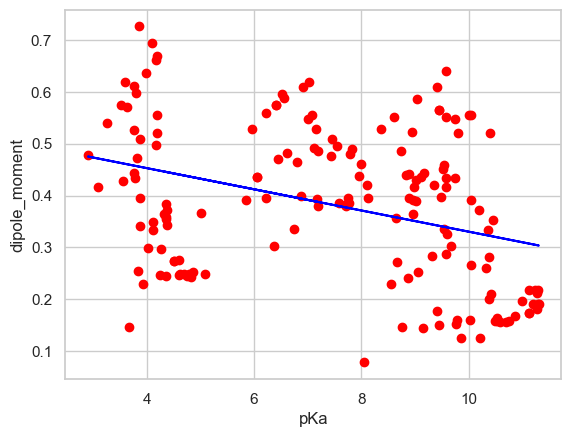

Amount of feature: f_freedom: 2
Mann-Whitney U for f_freedom: 1926.00
P-value: 0.0000
There is a statistically significant difference between the groups


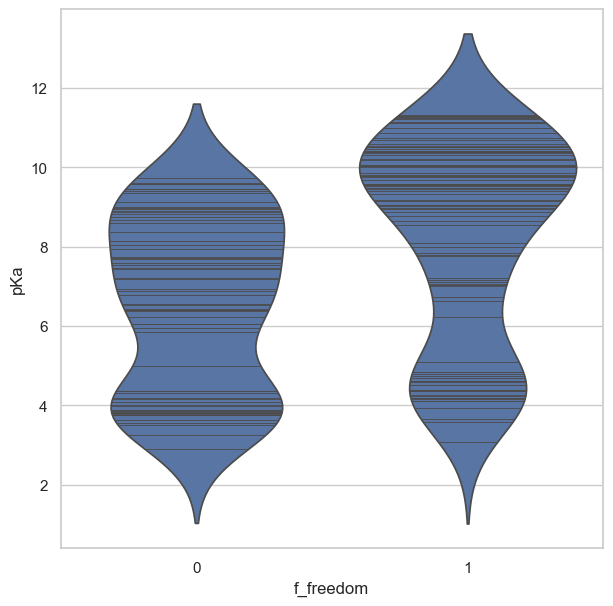

Amount of feature: f_to_fg: 6
Kruskal for f_to_fg: 21.97
P-value: 0.0005
There is a statistically significant difference between the groups


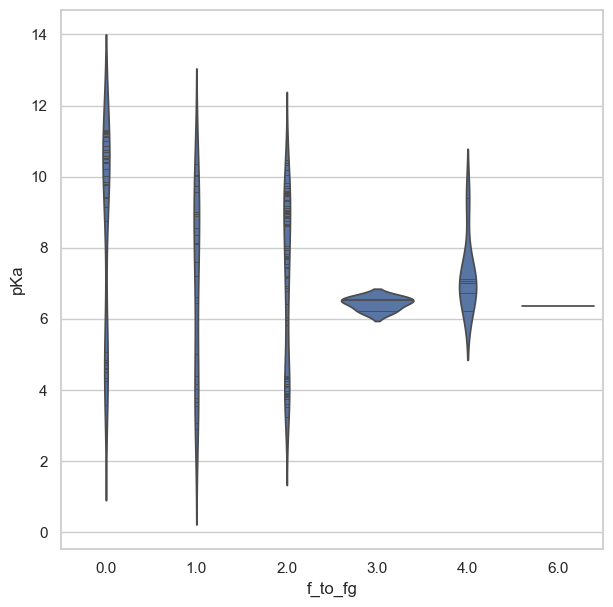

Amount of feature: mol_weight: 66
R^2 score: 0.3269640411347174
{'mse': 584.125, 'mae': 19.338, 'r_score': 0.327}


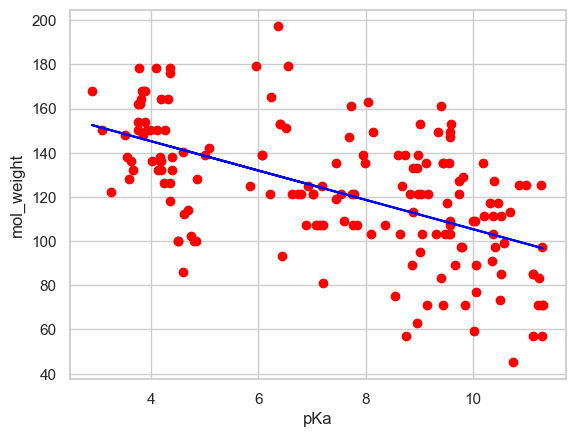

Amount of feature: nF: 5
Kruskal for nF: 31.94
P-value: 0.0000
There is a statistically significant difference between the groups


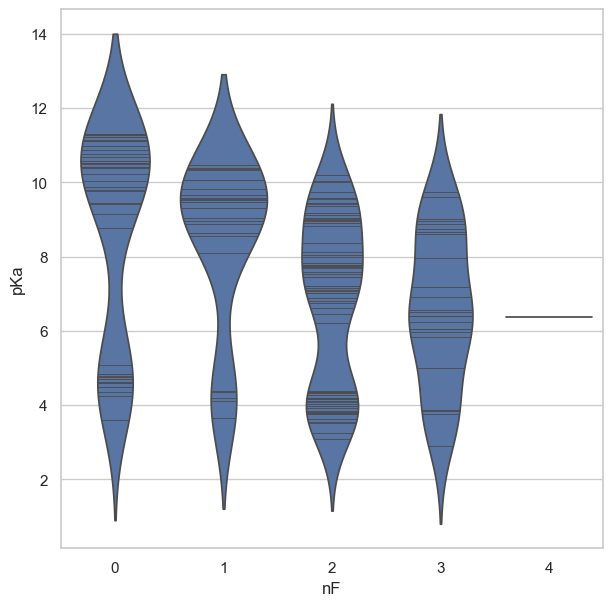

Amount of feature: TASA: 168
R^2 score: 0.2433531987095237
{'mse': 1793.273, 'mae': 33.317, 'r_score': 0.243}


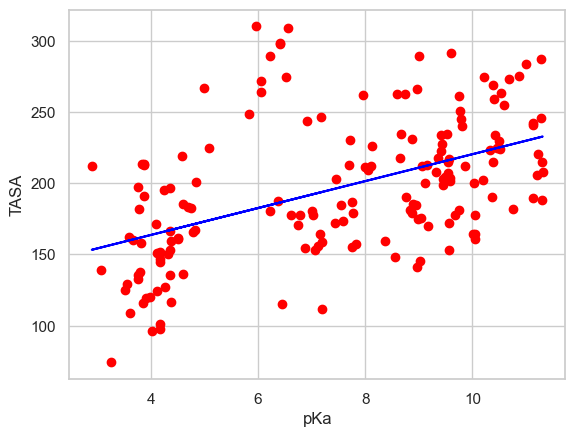

Amount of feature: mol_weight: 66
R^2 score: 0.3269640411347174
{'mse': 584.125, 'mae': 19.338, 'r_score': 0.327}


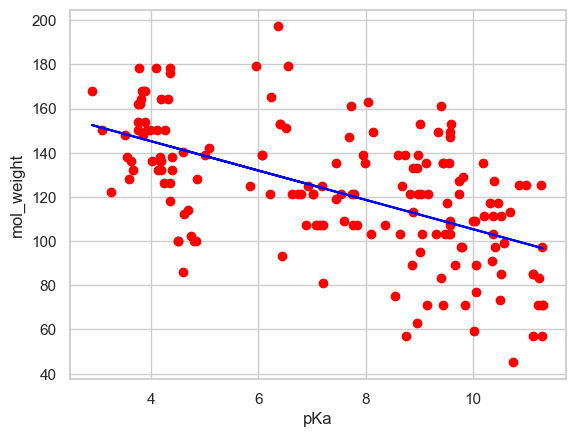

Amount of feature: nC: 7
Kruskal for nC: 14.51
P-value: 0.0244
There is a statistically significant difference between the groups


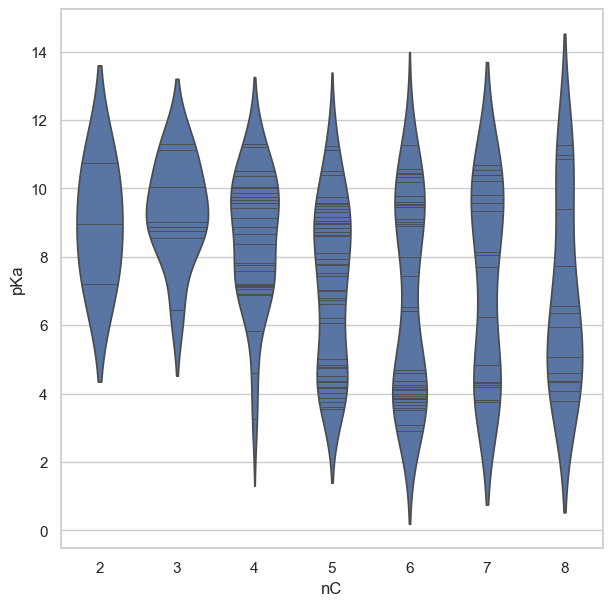

Amount of feature: nFHRing: 2
Mann-Whitney U for nFHRing: 960.00
P-value: 0.0208
There is a statistically significant difference between the groups


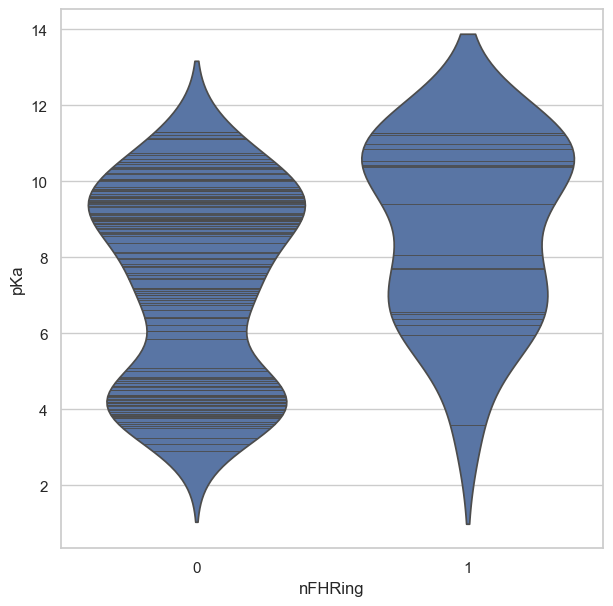

Amount of feature: identificator: 3
Kruskal for identificator: 104.97
P-value: 0.0000
There is a statistically significant difference between the groups


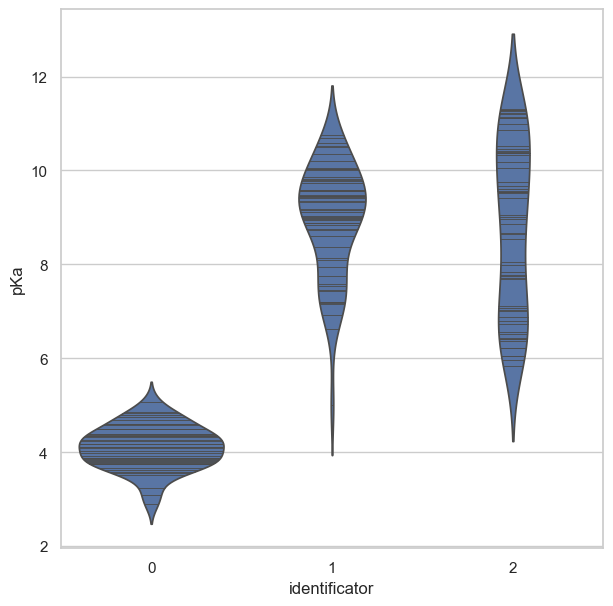

Amount of feature: nHRing: 3
Kruskal for nHRing: 21.23
P-value: 0.0000
There is a statistically significant difference between the groups


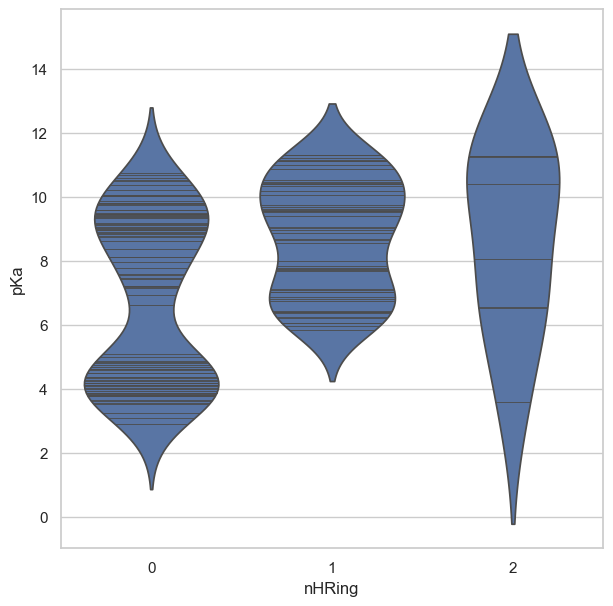

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress, mannwhitneyu, kruskal
import seaborn

seaborn.set_theme(style = 'whitegrid') 


def complete_mannwhitneyu_test(values1, values2, feature_name):
    result = mannwhitneyu(values1, values2, alternative='two-sided')

    print(f"Mann-Whitney U for {feature_name}: {result.statistic:.2f}")
    print(f"P-value: {result.pvalue:.4f}")

    if result.pvalue < 0.05:
        print("There is a statistically significant difference between the groups")
    else:
        print("There isn't any statistically significant difference between the groups")

    return result.pvalue


def complete_kruskal_test(groups, feature_name):
    result = kruskal(*groups)

    print(f"Kruskal for {feature_name}: {result.statistic:.2f}")
    print(f"P-value: {result.pvalue:.4f}")

    if result.pvalue < 0.05:
        print("There is a statistically significant difference between the groups")
    else:
        print("There isn't any statistically significant difference between the groups")
    
    return result.pvalue


# feature_names = df_features.columns
feature_names = ['FPSA3',
 'GeomShapeIndex',
 'PNSA5',
 'PPSA5',
 'RPCS',
 'TASA',
 'cis/trans',
 'dipole_moment',
 'f_freedom',
 'f_to_fg',
 'identificator',
 'mol_weight',
 'nC',
 'nF',
 'nFHRing',
 'nHRing',
 'nN',
 'nO']
feature_names.append('pKa')
remained_features = set()

for factor_index in range(n_factors):
    factor_representation = fa.loadings_[:, factor_index]

    for feature_index in range(len(feature_names)):
        if abs(factor_representation[feature_index]) < 0.5:
            continue

        if feature_names[feature_index] == 'pKa':
            continue
        
        feature_name = feature_names[feature_index]
        # print(f"Factor: {factor_index}, feature: {feature_names[feature_index]}, representation: {factor_representation[feature_index]}, logP repsentation: {factor_representation[-1]}")

        _x = list(df_features['pKa'])
        _y = list(df_features[feature_names[feature_index]])
        x, y = [], []
        for index in range(len(_x)):
            if _y[index] == 0 and ("angle" in feature_names[feature_index] or "distance" in feature_names[feature_index]):
                continue
            else:
                x.append(_x[index])
                y.append(_y[index])


        print(f"Amount of feature: {feature_name}: {len(set(y))}")
        if len(set(y)) > 15:
            slope, intercept, r, p, se = linregress(x, y)
            y_line = [slope * xi + intercept for xi in x]

            r_2 = pow(r, 2)
            if r_2 > 0.1:
                remained_features.add(feature_name)
                
            print(f"R^2 score: {r_2}")
            print(calculate_metrics(y, y_line))

            plt.scatter(x=x, y=y, color="red")
            plt.plot(x, y_line, color="blue")
            plt.xlabel('pKa')
            plt.ylabel(feature_names[feature_index])
            plt.show()
            # break

        else:

            df_dict = {}
            vals, names, xs = [],[],[]
            for i, unique_values in enumerate(sorted(set(y))):
                values = df_features[df_features[feature_name] == unique_values]['pKa']
                vals.append(values)
                names.append(f"{feature_name}: {i}")
                df_dict[f"{feature_name}: {unique_values}"] = values
                xs.append(np.random.normal(unique_values, 0.08, values.shape[0])) 

            if len(set(y)) == 2:
                values1 = df_features[df_features[feature_name] == list(set(y))[0]]['pKa']
                values2 = df_features[df_features[feature_name] == list(set(y))[1]]['pKa']
                pvalue = complete_mannwhitneyu_test(values1=values1, 
                                           values2=values2, 
                                           feature_name=feature_name)
            else:
                pvalue = complete_kruskal_test(groups=vals, 
                                      feature_name=feature_name)
            
            if pvalue < 0.05:
                remained_features.add(feature_name)
            df = pd.DataFrame(df_dict)

            plt.figure(figsize=(7,7))
            seaborn.violinplot(x=feature_name, y ='pKa',
                               data = df_features,
                               inner="stick")
            plt.show()
            
                


-----------

AMINE MOLECULES

----------------

In [19]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_pKa_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = ['dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=True,
                                           molecule_type="amine",
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=False,
                                           outliers_features_to_skip=unimportant_features_to_drop)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)
    # elif "angle" in feature_name or "distance" in feature_name:
    #     features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=True,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

merged_dataframe = pd.concat([train_df, test_df], axis=0)

True
128
['RPCS', 'PBF', 'mol_weight', 'dipole_moment', 'PPSA5', 'avg_atoms_in_cycle', 'nHRing', 'cis/trans', 'f_atom_fraction', 'dihedral_angle', 'FPSA3', 'distance_between_atoms_in_cycle_and_f_group', 'angle_X1X2R2', 'nF', 'angle_R1X1R2', 'nFAHRing', 'nAHRing', 'chirality', 'sasa', 'PNSA5', 'GeomShapeIndex', 'TASA', 'angle_R2X2R1', 'mol_num_cycles', 'naRing', 'nN', 'f_freedom', 'tpsa+f', 'nFRing', 'identificator', 'nO', 'distance_between_atoms_in_f_group_centers', 'angle_X2X1R1', 'nARing', 'nFARing', 'nC', 'nFHRing', 'f_to_fg', 'pKa', 'logP']
mol_weight outliers indexes: [28]
f_atom_fraction outliers indexes: [69]
distance_between_atoms_in_cycle_and_f_group outliers indexes: [112 113]
sasa outliers indexes: [72]
logP outliers indexes: [27]
Remains rows:118, amount of features: 40
feature without unique values: nN
100 18


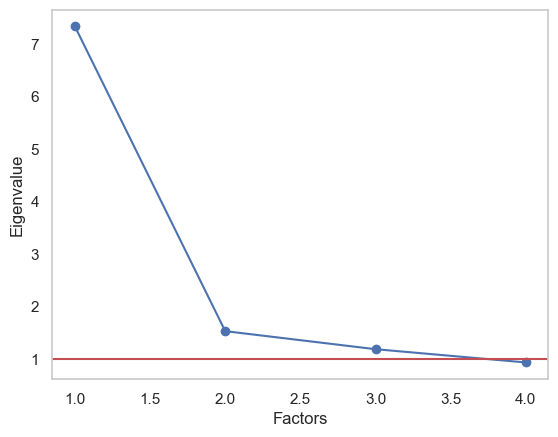

In [20]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# train_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\train_logP_v3.csv', index_col=0)
# test_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\test_logP_v3.csv', index_col=0)

features_to_analyse = []
for feature_name in merged_dataframe.columns:
    if len(merged_dataframe[feature_name].unique()) != 1:
        features_to_analyse.append(feature_name)
features_to_analyse.remove('fold_id')

features_to_drop = ['nFAHRing', 'nFHRing', 'fold_id']

for feature_to_drop in features_to_drop:
    if feature_to_drop in features_to_analyse:
        features_to_analyse.remove(feature_to_drop)

fa = FactorAnalyzer(rotation=None)

features_to_analyse = ['FPSA3',
 'PNSA5',
 'PPSA5',
 'RPCS',
 'chirality',
 'dipole_moment',
 'distance_between_atoms_in_cycle_and_f_group',
 'distance_between_atoms_in_f_group_centers',
 'f_freedom',
 'f_to_fg',
 'mol_weight',
 'nF',
 "pKa"]

df_features = merged_dataframe[features_to_analyse]
# df_features = StandardScaler().fit_transform(df_features)
fa.fit(df_features)

ev, _ = fa.get_eigenvalues()
for index, en_value in enumerate(ev):
    if en_value < 1:
        break
index += 1

plt.scatter(range(1, index + 1), ev[:index])
plt.plot(range(1, index + 1), ev[:index])
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y = 1, color='r')
plt.grid()
plt.show()

In [21]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(df_features)
kmo_model

0.7270535294185023

In [22]:
from sklearn.preprocessing import StandardScaler

n_factors = 2

fa = FactorAnalyzer(n_factors=n_factors, rotation="varimax")

fa.fit(df_features)

fa_load = pd.DataFrame(fa.loadings_,index=df_features.columns)
fa_load.style.background_gradient(cmap="coolwarm")

,0,1
FPSA3,-0.612700,-0.030922
PNSA5,-0.593516,-0.459246
PPSA5,0.739618,0.373040
RPCS,-0.773807,-0.213086
chirality,0.077581,0.278367
dipole_moment,0.624077,0.439013
distance_between_atoms_in_cycle_and_f_group,0.229861,0.899662
distance_between_atoms_in_f_group_centers,0.246490,0.898147
f_freedom,-0.767117,-0.188642
f_to_fg,0.389617,0.805899


In [30]:
fa_load.keys()

RangeIndex(start=0, stop=2, step=1)

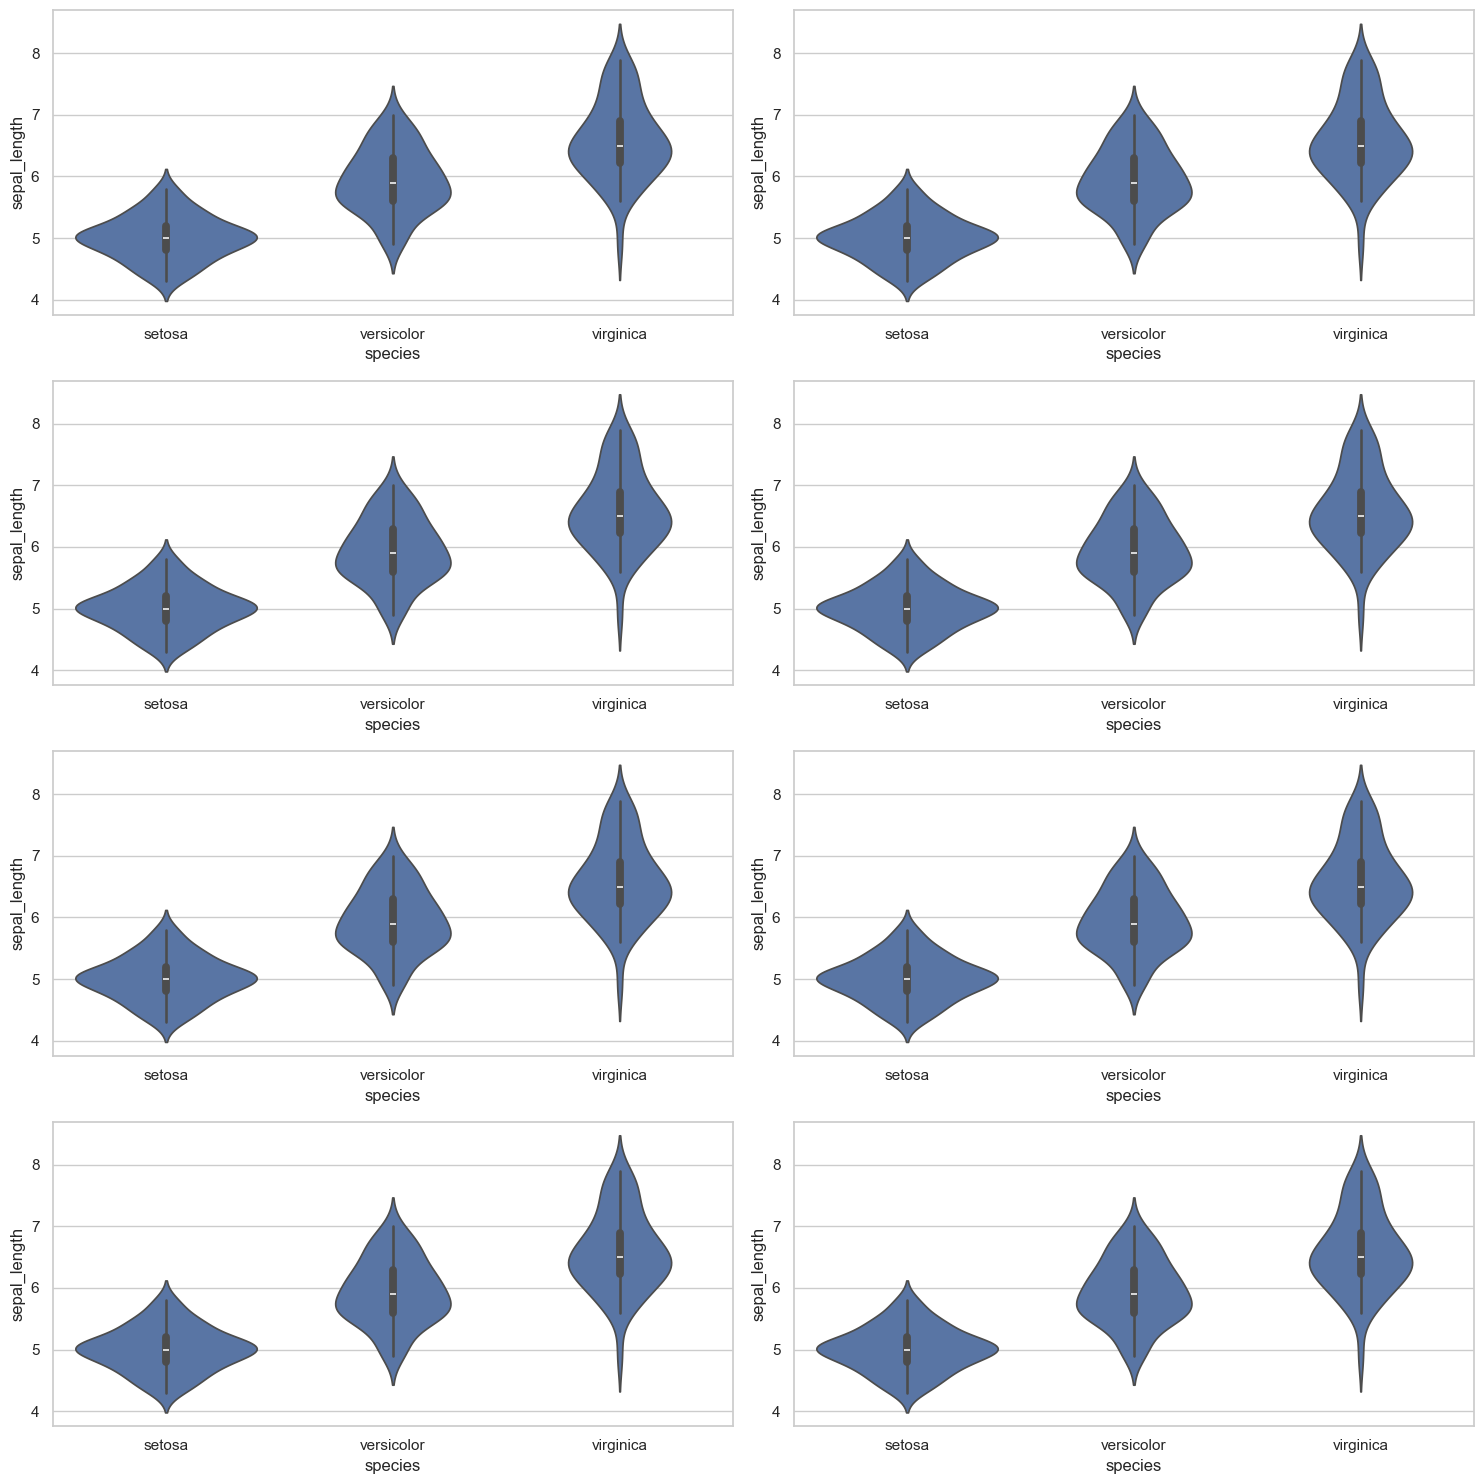

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Створюємо дані для прикладу
data = sns.load_dataset('iris')

fig, axs = plt.subplots(4, 2, figsize=(15, 15))

for i in range(4):
    for j in range(2):
        sns.violinplot(x=data['species'], y=data['sepal_length'], ax=axs[i, j])

plt.tight_layout()
plt.show()


R^2 score: 0.14793366689987317
{'mse': 0.0, 'mae': 0.004, 'r_score': 0.148}
R^2 score: 0.4783729974296502
{'mse': 25.749, 'mae': 4.39, 'r_score': 0.478}
R^2 score: 0.5049696606110778
{'mse': 1.063, 'mae': 0.807, 'r_score': 0.505}
R^2 score: 0.26456973207248813
{'mse': 1431.027, 'mae': 28.59, 'r_score': 0.265}
R^2 score: 0.34263588574532217
{'mse': 0.014, 'mae': 0.095, 'r_score': 0.343}
Mann-Whitney U for f_freedom: 571.00
P-value: 0.0000
There is a statistically significant difference between the groups
R^2 score: 0.25684741599883365
{'mse': 596.138, 'mae': 20.012, 'r_score': 0.257}
Kruskal for nF: 70.01
P-value: 0.0000
There is a statistically significant difference between the groups
['FPSA3', 'PNSA5', 'PPSA5', 'RPCS', 'dipole_moment', 'f_freedom', 'mol_weight', 'nF']
R^2 score: 0.16524381184015147
{'mse': 0.258, 'mae': 0.438, 'r_score': 0.165}
R^2 score: 0.2572779019908939
{'mse': 0.367, 'mae': 0.511, 'r_score': 0.257}
Kruskal for f_to_fg: 61.38
P-value: 0.0000
There is a statistica

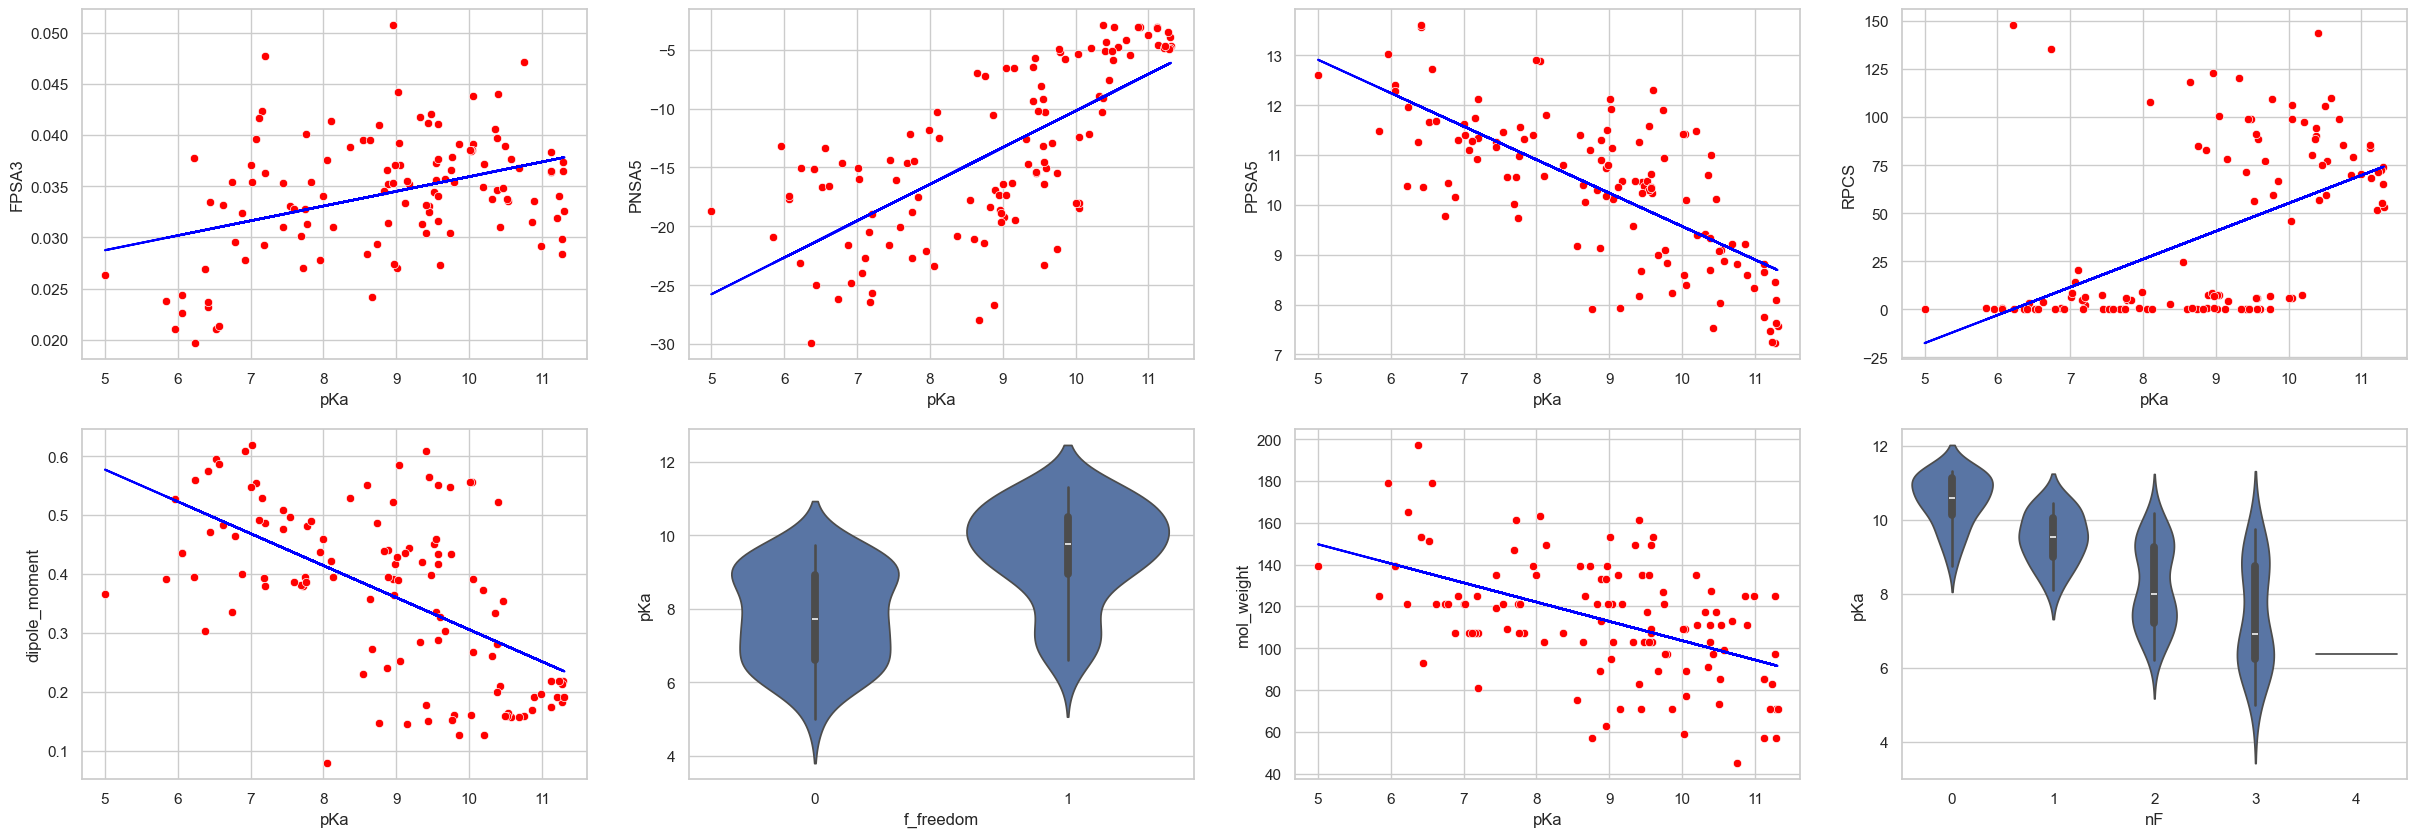

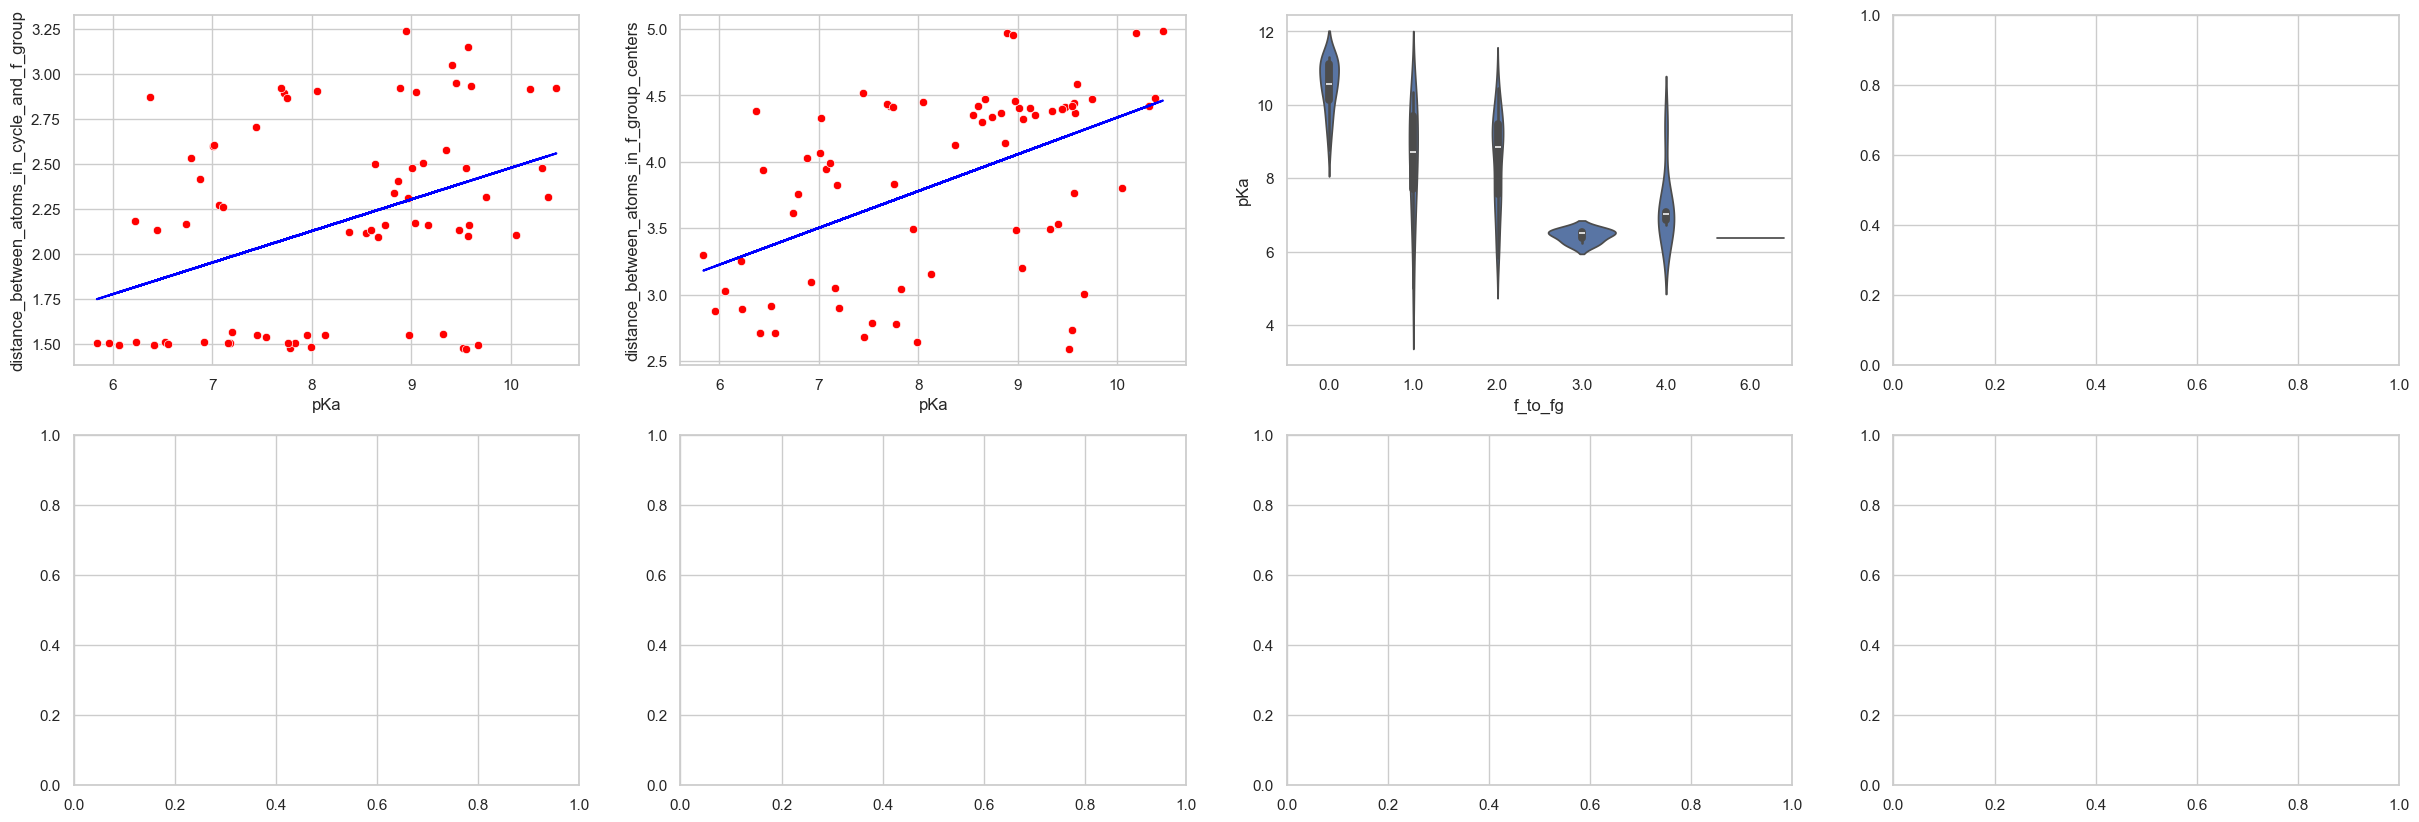

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

target_name = "pKa"

n_rows = 2
n_columns = 4

for factor_index in fa_load.keys():
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(30, 10))
    factor_top_features = []
    ax_index = 0
    for feature_name in fa_load[factor_index].keys():
        if abs(fa_load[factor_index][feature_name]) > 0.5 and feature_name != target_name:
            factor_top_features.append(feature_name)

            _x = list(df_features['pKa'])
            _y = list(df_features[feature_name])
            x, y = [], []
            for index in range(len(_x)):
                if _y[index] == 0 and ("angle" in feature_name or "distance" in feature_name):
                    continue
                else:
                    x.append(_x[index])
                    y.append(_y[index])

            if len(set(y)) > 15:
                slope, intercept, r, p, se = linregress(x, y)
                y_line = [slope * xi + intercept for xi in x]

                r_2 = pow(r, 2)
                if r_2 > 0.1:
                    remained_features.add(feature_name)
                    
                print(f"R^2 score: {r_2}")
                print(calculate_metrics(y, y_line))

                sns.scatterplot(x=x, y=y, ax=axs[ax_index // n_columns, ax_index % n_columns], color="red")
                axs[ax_index // n_columns, ax_index % n_columns].plot(x, y_line, color="blue")
                axs[ax_index // n_columns, ax_index % n_columns].set_ylabel(feature_name)
                axs[ax_index // n_columns, ax_index % n_columns].set_xlabel("pKa")
                # sns.plot(x, y_line, color="blue")

                # plt.scatter(x=x, y=y, color="red")
                # plt.plot(x, y_line, color="blue")
                # plt.xlabel('pKa')
                # plt.ylabel(feature_names[feature_index])
                # plt.show()
                # break

            else:

                df_dict = {}
                vals, names, xs = [],[],[]
                for i, unique_values in enumerate(sorted(set(y))):
                    values = df_features[df_features[feature_name] == unique_values]['pKa']
                    vals.append(values)
                    names.append(f"{feature_name}: {i}")
                    df_dict[f"{feature_name}: {unique_values}"] = values
                    xs.append(np.random.normal(unique_values, 0.08, values.shape[0])) 

                if len(set(y)) == 2:
                    values1 = df_features[df_features[feature_name] == list(set(y))[0]]['pKa']
                    values2 = df_features[df_features[feature_name] == list(set(y))[1]]['pKa']
                    pvalue = complete_mannwhitneyu_test(values1=values1, 
                                            values2=values2, 
                                            feature_name=feature_name)
                else:
                    pvalue = complete_kruskal_test(groups=vals, 
                                        feature_name=feature_name)
                
                if pvalue < 0.05:
                    remained_features.add(feature_name)
                df = pd.DataFrame(df_dict)

                sns.violinplot(x=feature_name, y='pKa', data = df_features,  ax=axs[ax_index // n_columns, ax_index % n_columns])
                # seaborn.violinplot(x=feature_name, y ='pKa',
                #                 data = df_features,
                #                 inner="stick")
            ax_index += 1

            
    print(factor_top_features)

Amount of feature: FPSA3: 117
R^2 score: 0.14793366689987317
{'mse': 0.0, 'mae': 0.004, 'r_score': 0.148}


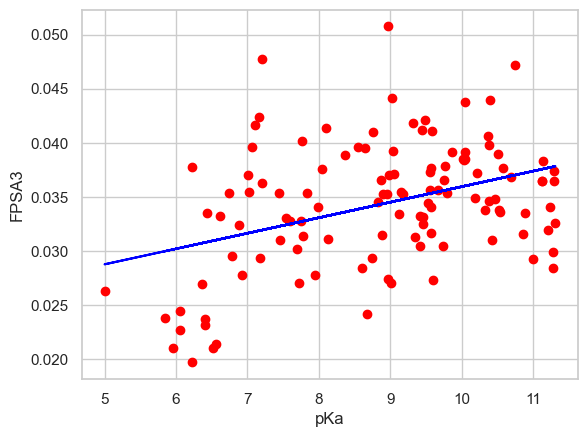

Amount of feature: PNSA5: 117
R^2 score: 0.4783729974296502
{'mse': 25.749, 'mae': 4.39, 'r_score': 0.478}


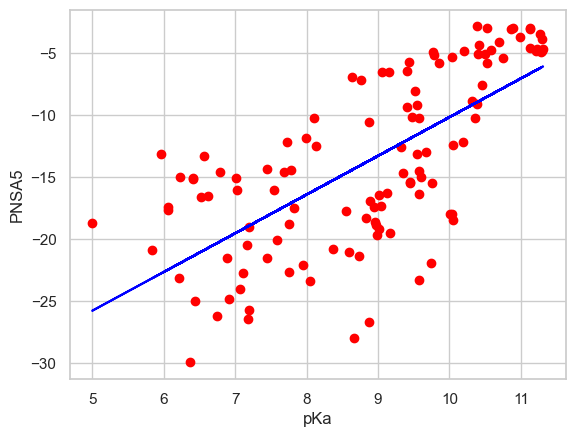

Amount of feature: PPSA5: 117
R^2 score: 0.5049696606110778
{'mse': 1.063, 'mae': 0.807, 'r_score': 0.505}


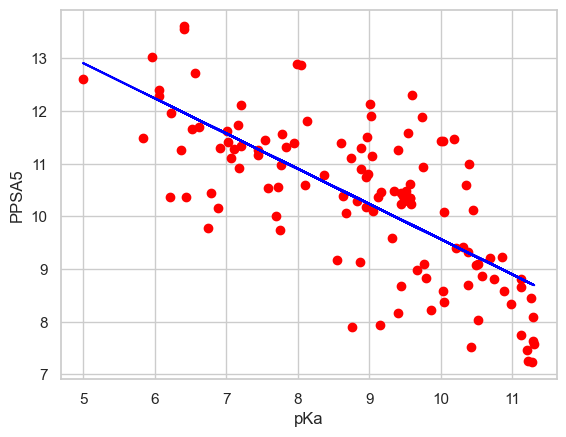

Amount of feature: RPCS: 100
R^2 score: 0.26456973207248813
{'mse': 1431.027, 'mae': 28.59, 'r_score': 0.265}


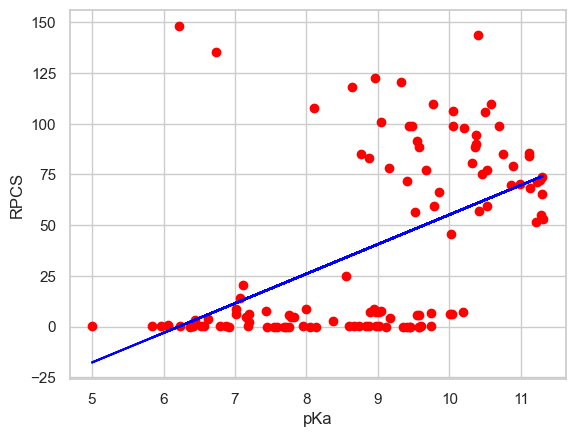

Amount of feature: dipole_moment: 117
R^2 score: 0.34263588574532217
{'mse': 0.014, 'mae': 0.095, 'r_score': 0.343}


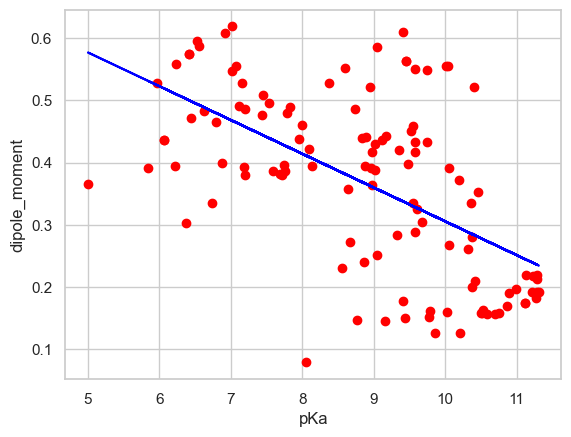

Amount of feature: f_freedom: 2
Mann-Whitney U for f_freedom: 571.00
P-value: 0.0000
There is a statistically significant difference between the groups


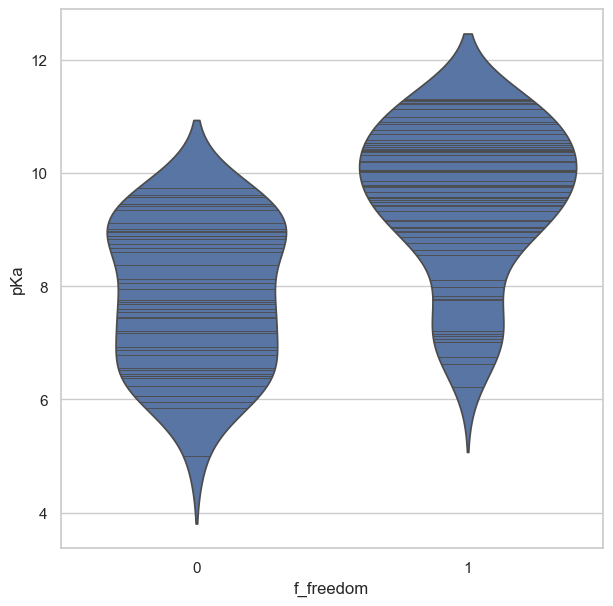

Amount of feature: mol_weight: 42
R^2 score: 0.25684741599883365
{'mse': 596.138, 'mae': 20.012, 'r_score': 0.257}


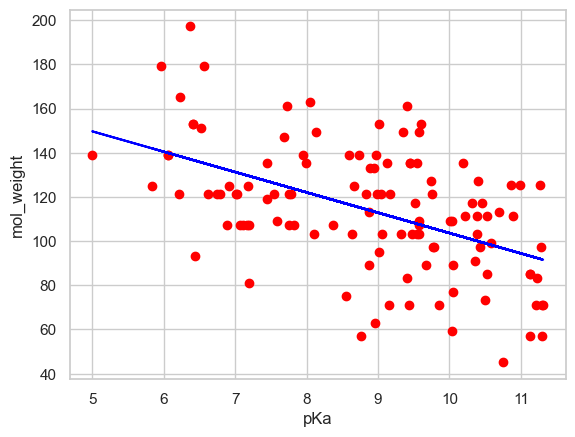

Amount of feature: nF: 5
Kruskal for nF: 70.01
P-value: 0.0000
There is a statistically significant difference between the groups


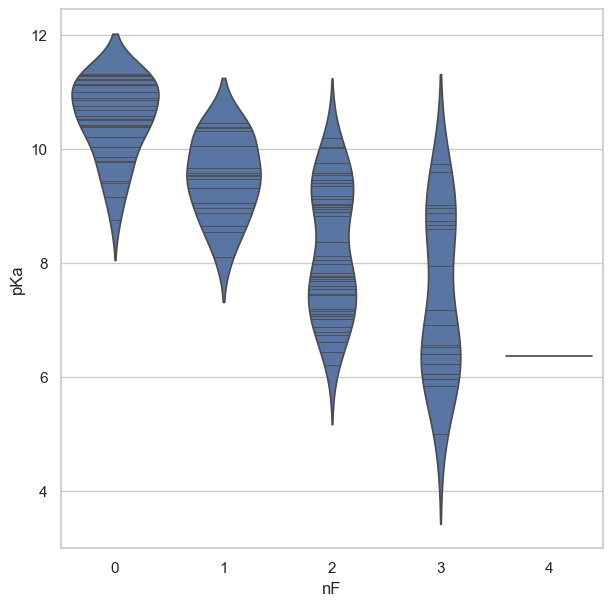

Amount of feature: distance_between_atoms_in_cycle_and_f_group: 73
R^2 score: 0.16524381184015147
{'mse': 0.258, 'mae': 0.438, 'r_score': 0.165}


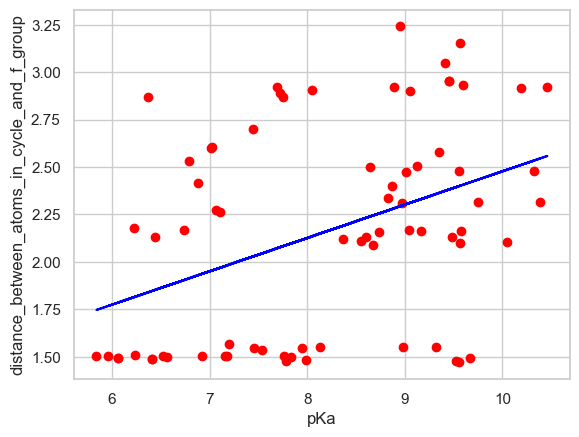

Amount of feature: distance_between_atoms_in_f_group_centers: 73
R^2 score: 0.2572779019908939
{'mse': 0.367, 'mae': 0.511, 'r_score': 0.257}


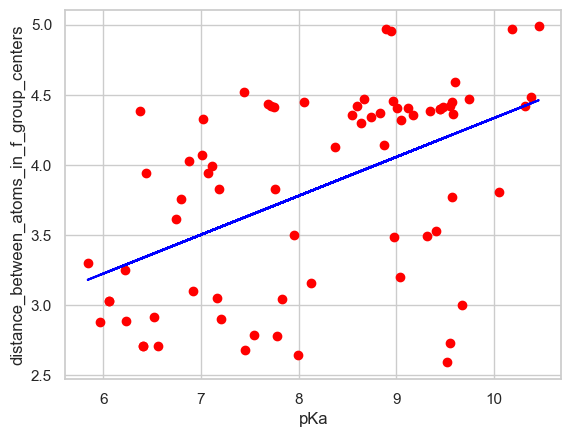

Amount of feature: f_to_fg: 6
Kruskal for f_to_fg: 61.38
P-value: 0.0000
There is a statistically significant difference between the groups


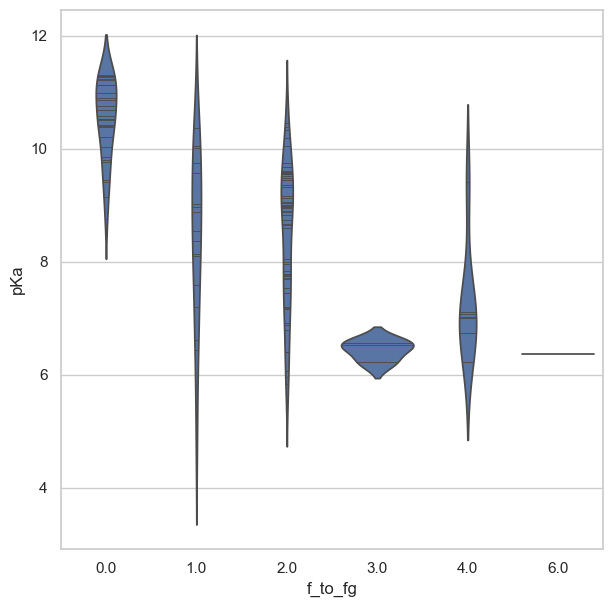

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress, mannwhitneyu, kruskal
import seaborn

seaborn.set_theme(style = 'whitegrid') 


def complete_mannwhitneyu_test(values1, values2, feature_name):
    result = mannwhitneyu(values1, values2, alternative='two-sided')

    print(f"Mann-Whitney U for {feature_name}: {result.statistic:.2f}")
    print(f"P-value: {result.pvalue:.4f}")

    if result.pvalue < 0.05:
        print("There is a statistically significant difference between the groups")
    else:
        print("There isn't any statistically significant difference between the groups")

    return result.pvalue


def complete_kruskal_test(groups, feature_name):
    result = kruskal(*groups)

    print(f"Kruskal for {feature_name}: {result.statistic:.2f}")
    print(f"P-value: {result.pvalue:.4f}")

    if result.pvalue < 0.05:
        print("There is a statistically significant difference between the groups")
    else:
        print("There isn't any statistically significant difference between the groups")
    
    return result.pvalue


# feature_names = df_features.columns
feature_names = ['FPSA3',
 'PNSA5',
 'PPSA5',
 'RPCS',
 'chirality',
 'dipole_moment',
 'distance_between_atoms_in_cycle_and_f_group',
 'distance_between_atoms_in_f_group_centers',
 'f_freedom',
 'f_to_fg',
 'mol_weight',
 'nF']
feature_names.append('pKa')
remained_features = set()

for factor_index in range(n_factors):
    factor_representation = fa.loadings_[:, factor_index]

    for feature_index in range(len(feature_names)):
        if abs(factor_representation[feature_index]) < 0.5:
            continue

        if feature_names[feature_index] == 'pKa':
            continue
        
        feature_name = feature_names[feature_index]
        # print(f"Factor: {factor_index}, feature: {feature_names[feature_index]}, representation: {factor_representation[feature_index]}, logP repsentation: {factor_representation[-1]}")

        _x = list(df_features['pKa'])
        _y = list(df_features[feature_names[feature_index]])
        x, y = [], []
        for index in range(len(_x)):
            if _y[index] == 0 and ("angle" in feature_names[feature_index] or "distance" in feature_names[feature_index]):
                continue
            else:
                x.append(_x[index])
                y.append(_y[index])


        print(f"Amount of feature: {feature_name}: {len(set(y))}")
        if len(set(y)) > 15:
            slope, intercept, r, p, se = linregress(x, y)
            y_line = [slope * xi + intercept for xi in x]

            r_2 = pow(r, 2)
            if r_2 > 0.1:
                remained_features.add(feature_name)
                
            print(f"R^2 score: {r_2}")
            print(calculate_metrics(y, y_line))

            plt.scatter(x=x, y=y, color="red")
            plt.plot(x, y_line, color="blue")
            plt.xlabel('pKa')
            plt.ylabel(feature_names[feature_index])
            plt.show()
            # break

        else:

            df_dict = {}
            vals, names, xs = [],[],[]
            for i, unique_values in enumerate(sorted(set(y))):
                values = df_features[df_features[feature_name] == unique_values]['pKa']
                vals.append(values)
                names.append(f"{feature_name}: {i}")
                df_dict[f"{feature_name}: {unique_values}"] = values
                xs.append(np.random.normal(unique_values, 0.08, values.shape[0])) 

            if len(set(y)) == 2:
                values1 = df_features[df_features[feature_name] == list(set(y))[0]]['pKa']
                values2 = df_features[df_features[feature_name] == list(set(y))[1]]['pKa']
                pvalue = complete_mannwhitneyu_test(values1=values1, 
                                           values2=values2, 
                                           feature_name=feature_name)
            else:
                pvalue = complete_kruskal_test(groups=vals, 
                                      feature_name=feature_name)
            
            if pvalue < 0.05:
                remained_features.add(feature_name)
            df = pd.DataFrame(df_dict)

            plt.figure(figsize=(7,7))
            seaborn.violinplot(x=feature_name, y ='pKa',
                               data = df_features,
                               inner="stick")
            plt.show()
            
                


----------------

ACID MOLECULES

-------------------

In [58]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_pKa_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = ['dipole_moment', 'RPCS']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=True,
                                           molecule_type="acid",
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=False,
                                           outliers_features_to_skip=unimportant_features_to_drop)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)
    # elif "angle" in feature_name or "distance" in feature_name:
    #     features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=True,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

merged_dataframe = pd.concat([train_df, test_df], axis=0)

True
55
['RPCS', 'PBF', 'mol_weight', 'dipole_moment', 'PPSA5', 'avg_atoms_in_cycle', 'nHRing', 'cis/trans', 'f_atom_fraction', 'dihedral_angle', 'FPSA3', 'distance_between_atoms_in_cycle_and_f_group', 'angle_X1X2R2', 'nF', 'angle_R1X1R2', 'nFAHRing', 'nAHRing', 'chirality', 'sasa', 'PNSA5', 'GeomShapeIndex', 'TASA', 'angle_R2X2R1', 'mol_num_cycles', 'naRing', 'nN', 'f_freedom', 'tpsa+f', 'nFRing', 'identificator', 'nO', 'distance_between_atoms_in_f_group_centers', 'angle_X2X1R1', 'nARing', 'nFARing', 'nC', 'nFHRing', 'f_to_fg', 'pKa', 'logP']
PBF outliers indexes: [40]
PPSA5 outliers indexes: [39, 40]
FPSA3 outliers indexes: [40]
GeomShapeIndex outliers indexes: [50]
logP outliers indexes: [48]
Remains rows:50, amount of features: 40
feature without unique values: nN
feature without unique values: identificator
42 8


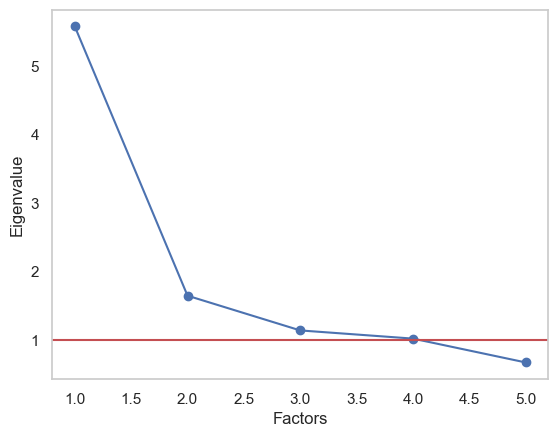

In [59]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# train_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\train_logP_v3.csv', index_col=0)
# test_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\test_logP_v3.csv', index_col=0)

features_to_analyse = []
for feature_name in merged_dataframe.columns:
    if len(merged_dataframe[feature_name].unique()) != 1:
        features_to_analyse.append(feature_name)
features_to_analyse.remove('fold_id')

features_to_drop = ['nFAHRing', 'nFHRing', 'fold_id']

for feature_to_drop in features_to_drop:
    if feature_to_drop in features_to_analyse:
        features_to_analyse.remove(feature_to_drop)

fa = FactorAnalyzer(rotation=None)

features_to_analyse = ['FPSA3',
 'PNSA5',
 'PPSA5',
 'dipole_moment',
 'distance_between_atoms_in_cycle_and_f_group',
 'f_freedom',
 'f_to_fg',
 'mol_weight',
 'nF',
 'nO',
 'pKa']

df_features = merged_dataframe[features_to_analyse]
# df_features = StandardScaler().fit_transform(df_features)
fa.fit(df_features)

ev, _ = fa.get_eigenvalues()
for index, en_value in enumerate(ev):
    if en_value < 1:
        break
index += 1

plt.scatter(range(1, index + 1), ev[:index])
plt.plot(range(1, index + 1), ev[:index])
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y = 1, color='r')
plt.grid()
plt.show()

In [60]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(df_features)
kmo_model

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.6636857778254484

In [64]:
from sklearn.preprocessing import StandardScaler

n_factors = 3

fa = FactorAnalyzer(n_factors=n_factors, rotation="varimax")

fa.fit(df_features)

fa_load = pd.DataFrame(fa.loadings_,index=df_features.columns)
fa_load.style.background_gradient(cmap="coolwarm")

,0,1,2
FPSA3,-0.158000,0.991223,-0.037288
PNSA5,-0.661322,0.105061,-0.524443
PPSA5,0.001291,-0.137415,0.592453
dipole_moment,0.461815,-0.249459,0.140005
distance_between_atoms_in_cycle_and_f_group,0.776582,-0.184887,-0.075105
f_freedom,-0.493265,0.612606,-0.141486
f_to_fg,0.957061,-0.151539,0.197980
mol_weight,0.540715,-0.593442,0.301140
nF,0.691721,-0.488500,0.406899
nO,0.096490,0.054607,0.543596


R^2 score: 0.4877343613366879
{'mse': 48.623, 'mae': 5.764, 'r_score': 0.488}
R^2 score: 0.14651969102861778
{'mse': 0.474, 'mae': 0.555, 'r_score': 0.147}
Kruskal for f_to_fg: 25.08
P-value: 0.0000
There is a statistically significant difference between the groups
R^2 score: 0.2966680024465359
{'mse': 399.051, 'mae': 16.168, 'r_score': 0.297}
Kruskal for nF: 27.87
P-value: 0.0000
There is a statistically significant difference between the groups
['PNSA5', 'distance_between_atoms_in_cycle_and_f_group', 'f_to_fg', 'mol_weight', 'nF']
R^2 score: 0.12231502164362709
{'mse': 0.0, 'mae': 0.003, 'r_score': 0.122}
Mann-Whitney U for f_freedom: 102.00
P-value: 0.0000
There is a statistically significant difference between the groups
R^2 score: 0.2966680024465359
{'mse': 399.051, 'mae': 16.168, 'r_score': 0.297}
['FPSA3', 'f_freedom', 'mol_weight']
R^2 score: 0.4877343613366879
{'mse': 48.623, 'mae': 5.764, 'r_score': 0.488}
R^2 score: 0.3934941964103632
{'mse': 0.325, 'mae': 0.44, 'r_score': 0

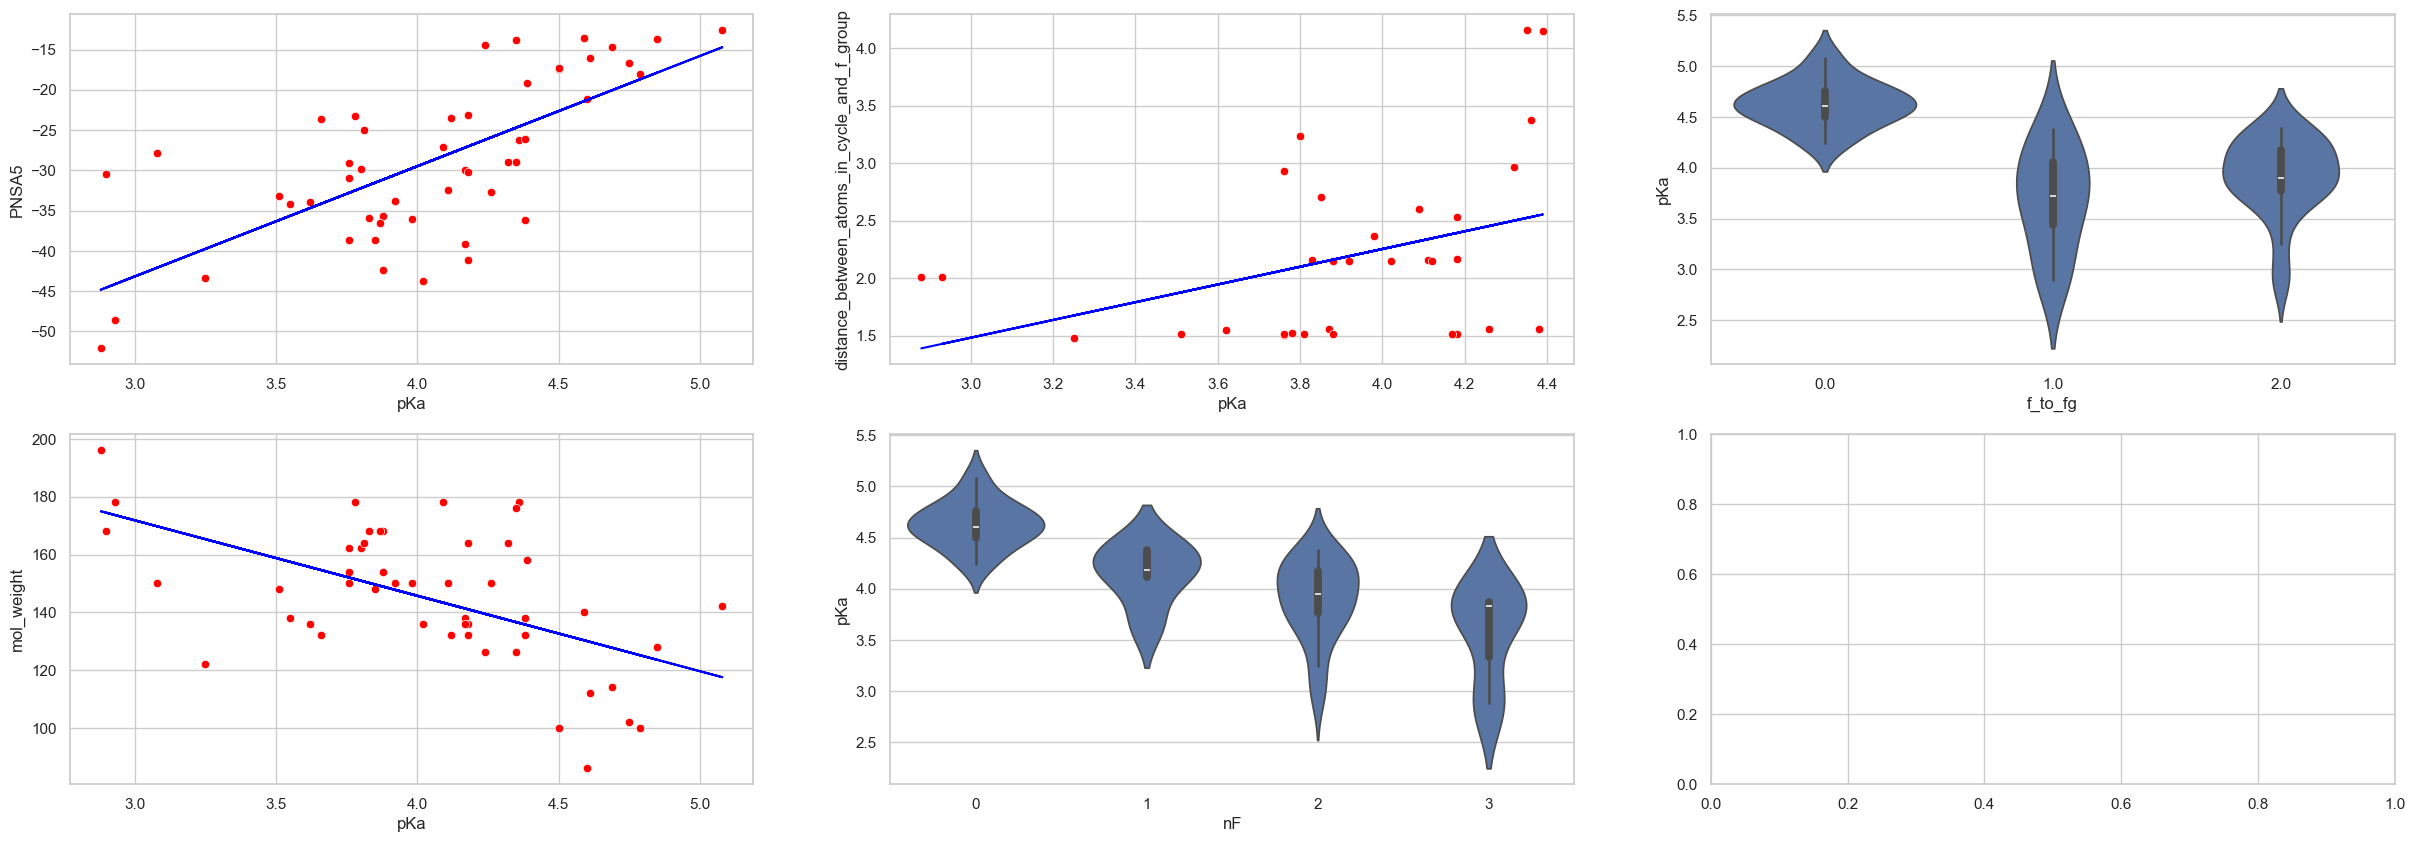

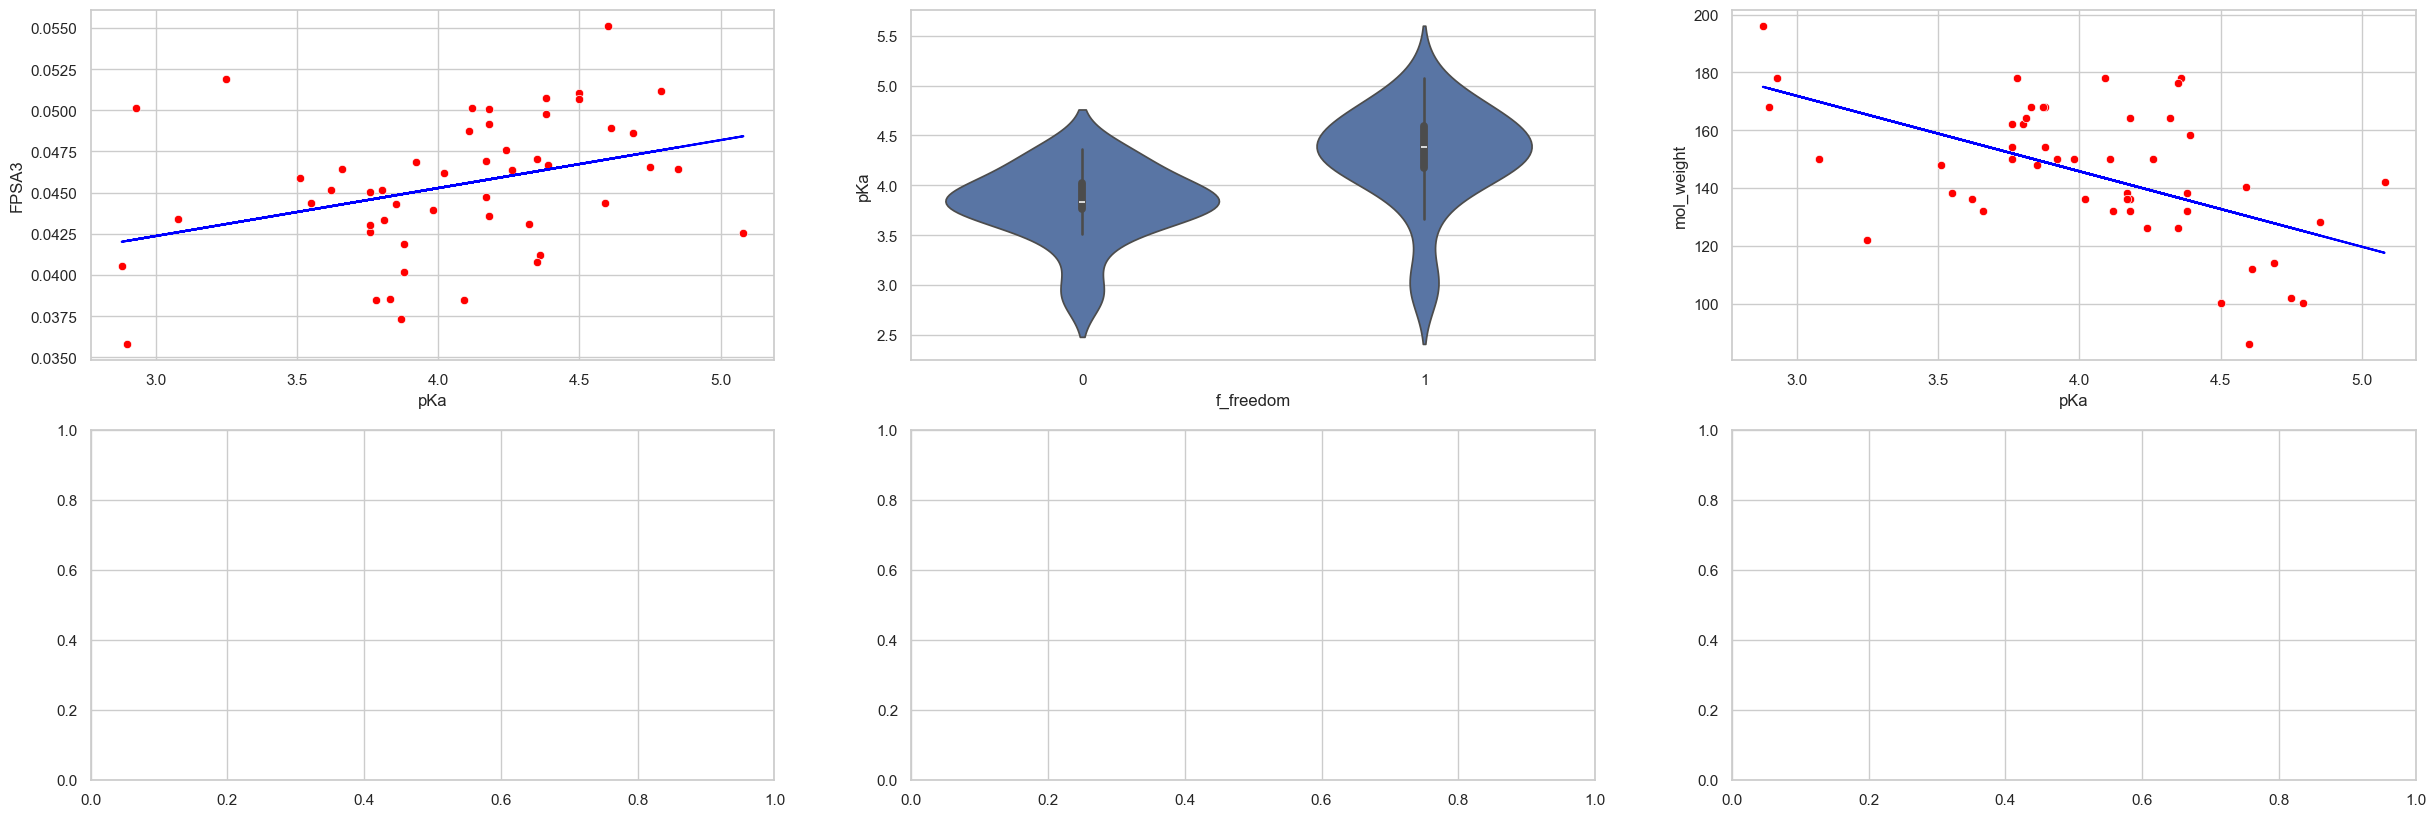

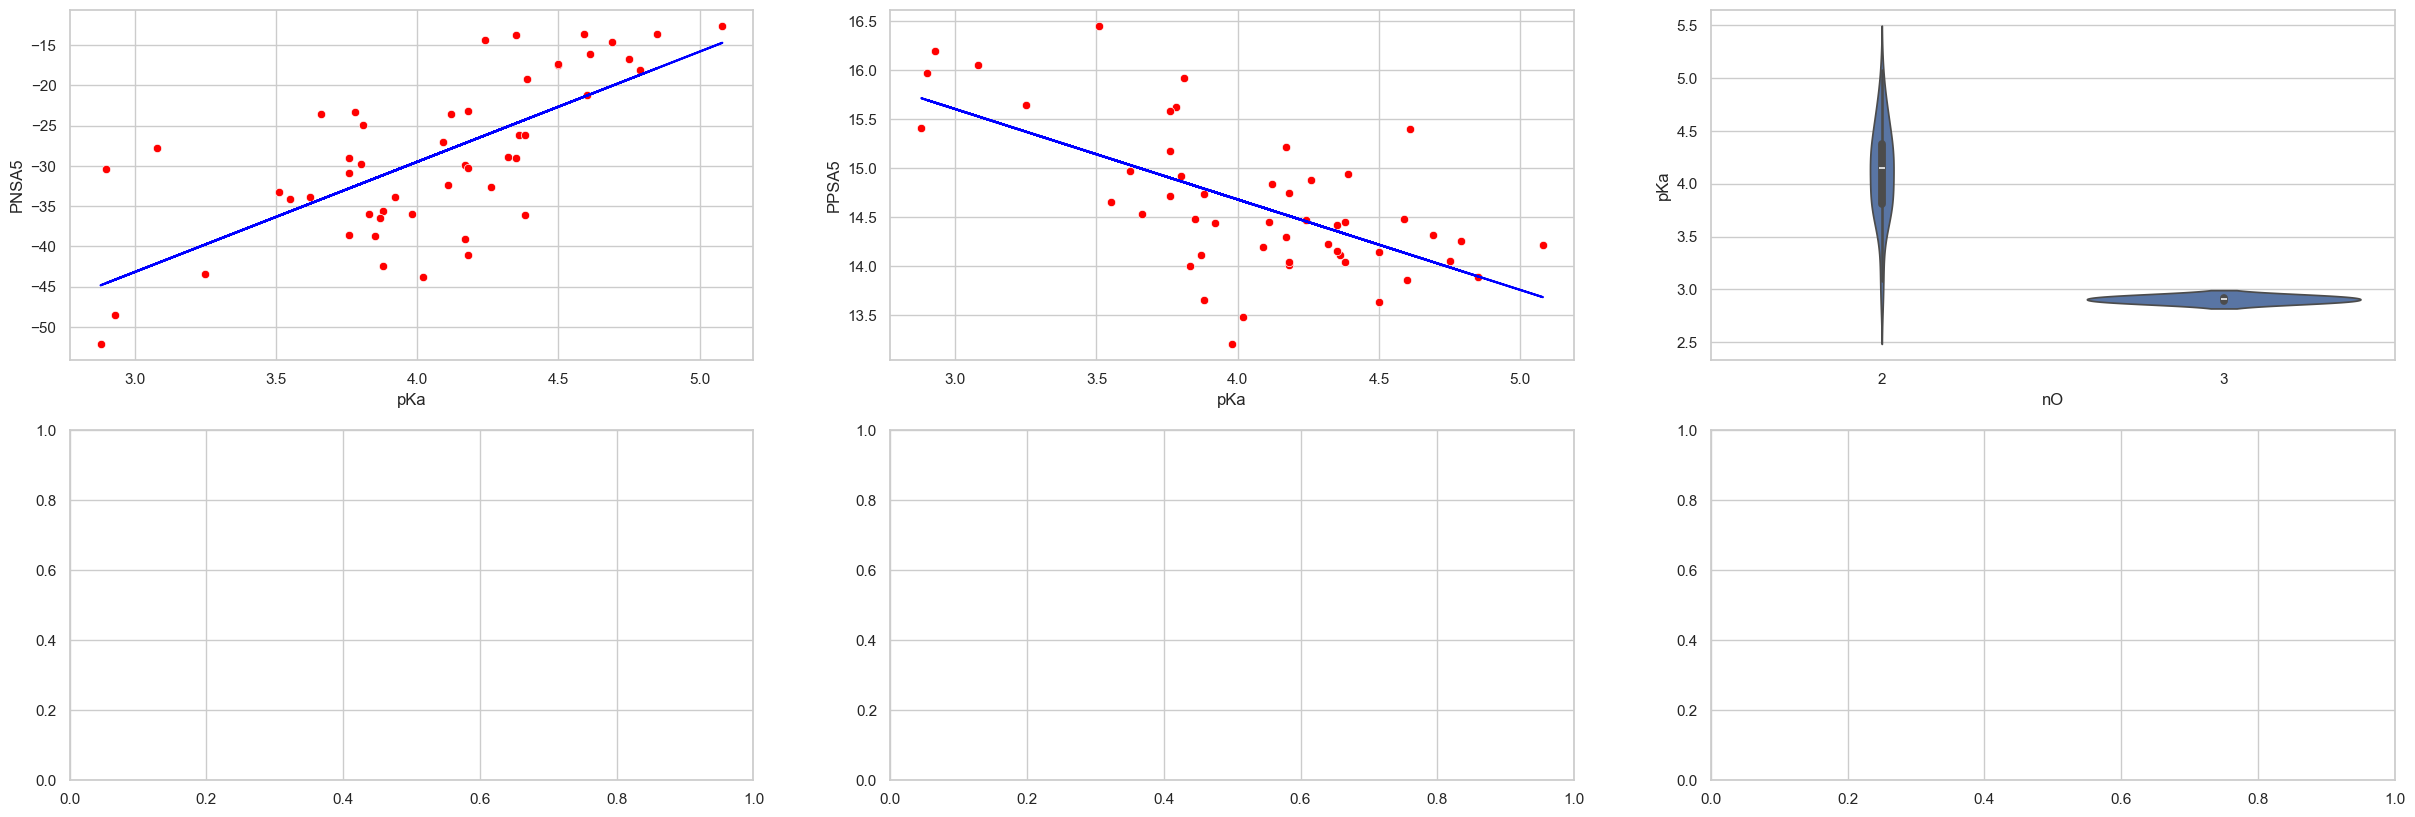

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

target_name = "pKa"

n_rows = 2
n_columns = 3

for factor_index in fa_load.keys():
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(30, 10))
    factor_top_features = []
    ax_index = 0
    for feature_name in fa_load[factor_index].keys():
        if abs(fa_load[factor_index][feature_name]) > 0.5 and feature_name != target_name:
            factor_top_features.append(feature_name)

            _x = list(df_features['pKa'])
            _y = list(df_features[feature_name])
            x, y = [], []
            for index in range(len(_x)):
                if _y[index] == 0 and ("angle" in feature_name or "distance" in feature_name):
                    continue
                else:
                    x.append(_x[index])
                    y.append(_y[index])

            if len(set(y)) > 15:
                slope, intercept, r, p, se = linregress(x, y)
                y_line = [slope * xi + intercept for xi in x]

                r_2 = pow(r, 2)
                if r_2 > 0.1:
                    remained_features.add(feature_name)
                    
                print(f"R^2 score: {r_2}")
                print(calculate_metrics(y, y_line))

                sns.scatterplot(x=x, y=y, ax=axs[ax_index // n_columns, ax_index % n_columns], color="red")
                axs[ax_index // n_columns, ax_index % n_columns].plot(x, y_line, color="blue")
                axs[ax_index // n_columns, ax_index % n_columns].set_ylabel(feature_name)
                axs[ax_index // n_columns, ax_index % n_columns].set_xlabel("pKa")
                # sns.plot(x, y_line, color="blue")

                # plt.scatter(x=x, y=y, color="red")
                # plt.plot(x, y_line, color="blue")
                # plt.xlabel('pKa')
                # plt.ylabel(feature_names[feature_index])
                # plt.show()
                # break

            else:

                df_dict = {}
                vals, names, xs = [],[],[]
                for i, unique_values in enumerate(sorted(set(y))):
                    values = df_features[df_features[feature_name] == unique_values]['pKa']
                    vals.append(values)
                    names.append(f"{feature_name}: {i}")
                    df_dict[f"{feature_name}: {unique_values}"] = values
                    xs.append(np.random.normal(unique_values, 0.08, values.shape[0])) 

                if len(set(y)) == 2:
                    values1 = df_features[df_features[feature_name] == list(set(y))[0]]['pKa']
                    values2 = df_features[df_features[feature_name] == list(set(y))[1]]['pKa']
                    pvalue = complete_mannwhitneyu_test(values1=values1, 
                                            values2=values2, 
                                            feature_name=feature_name)
                else:
                    pvalue = complete_kruskal_test(groups=vals, 
                                        feature_name=feature_name)
                
                if pvalue < 0.05:
                    remained_features.add(feature_name)
                df = pd.DataFrame(df_dict)

                sns.violinplot(x=feature_name, y='pKa', data = df_features,  ax=axs[ax_index // n_columns, ax_index % n_columns])
                # seaborn.violinplot(x=feature_name, y ='pKa',
                #                 data = df_features,
                #                 inner="stick")
            ax_index += 1

            
    print(factor_top_features)

Amount of feature: PPSA5: 50
R^2 score: 0.3934941964103632
{'mse': 0.325, 'mae': 0.44, 'r_score': 0.393}


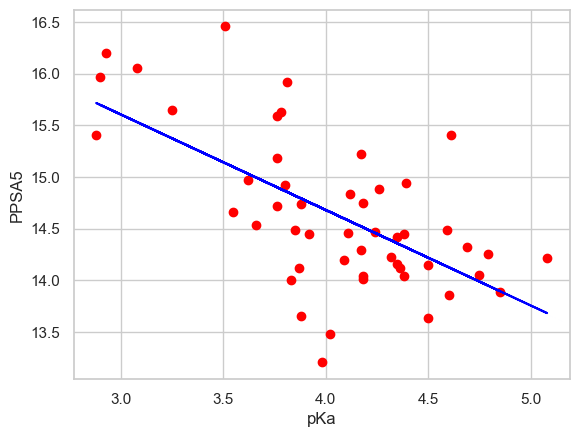

Amount of feature: nF: 4
Kruskal for nF: 27.87
P-value: 0.0000
There is a statistically significant difference between the groups


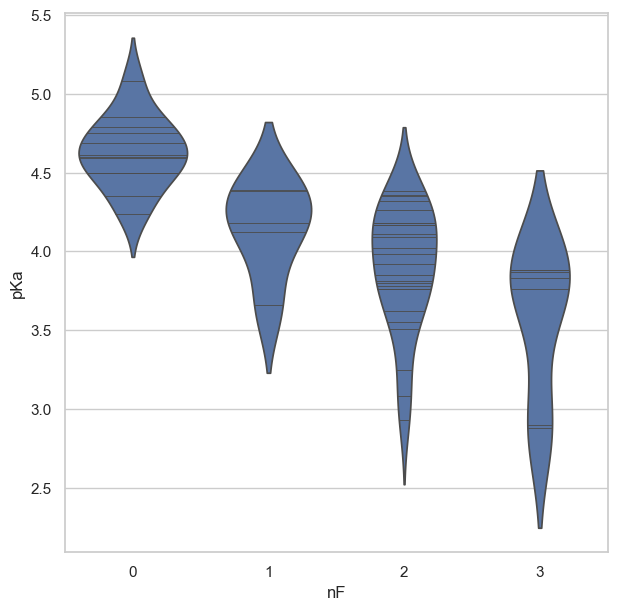

Amount of feature: nO: 2
Mann-Whitney U for nO: 95.00
P-value: 0.0213
There is a statistically significant difference between the groups


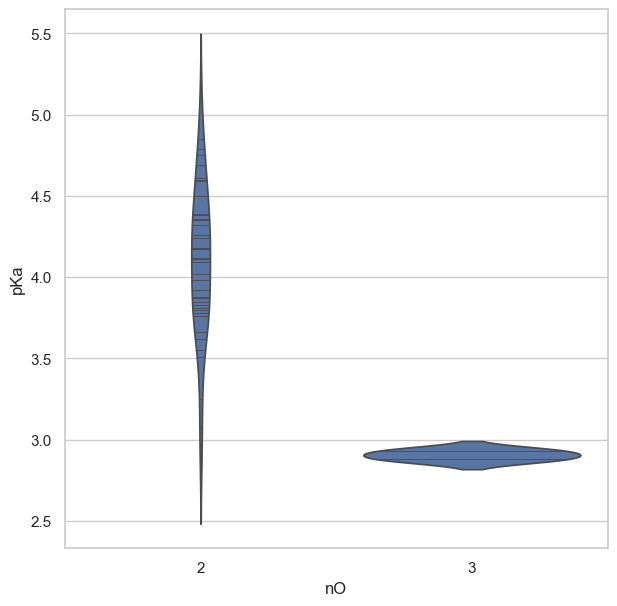

Amount of feature: f_to_fg: 3
Kruskal for f_to_fg: 25.08
P-value: 0.0000
There is a statistically significant difference between the groups


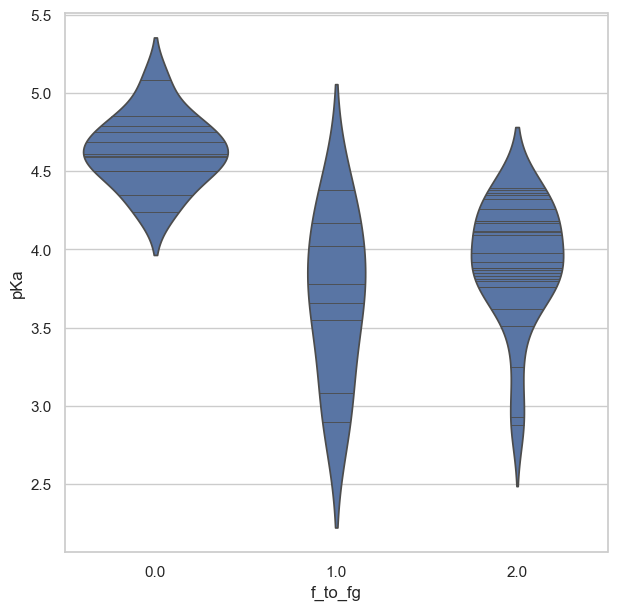

Amount of feature: f_freedom: 2
Mann-Whitney U for f_freedom: 102.00
P-value: 0.0000
There is a statistically significant difference between the groups


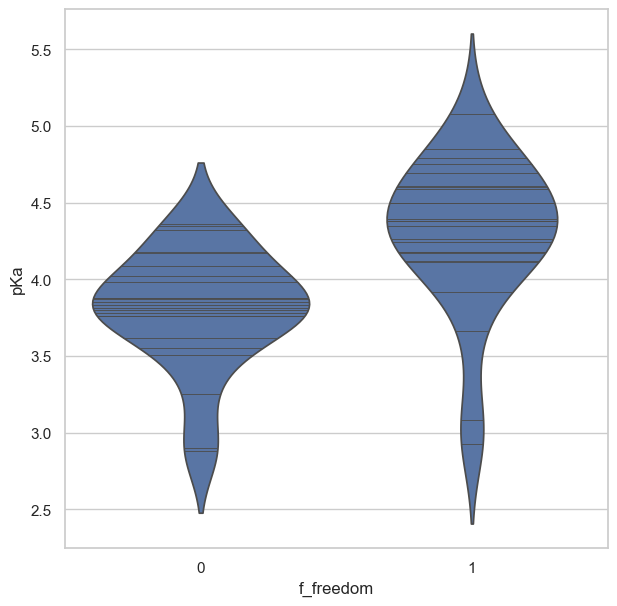

Amount of feature: dipole_moment: 50
R^2 score: 0.13688498861886697
{'mse': 0.02, 'mae': 0.109, 'r_score': 0.137}


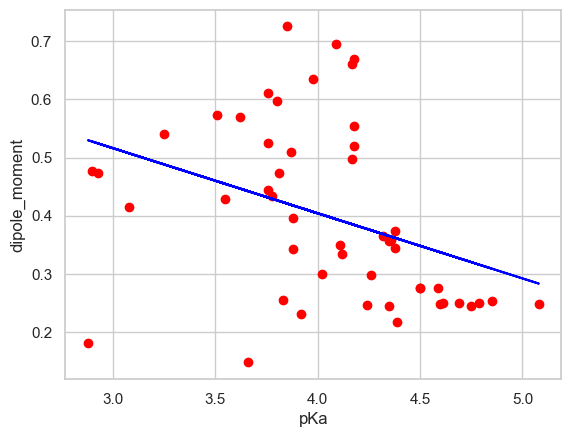

Amount of feature: nHRing: 2
Mann-Whitney U for nHRing: 95.00
P-value: 0.0213
There is a statistically significant difference between the groups


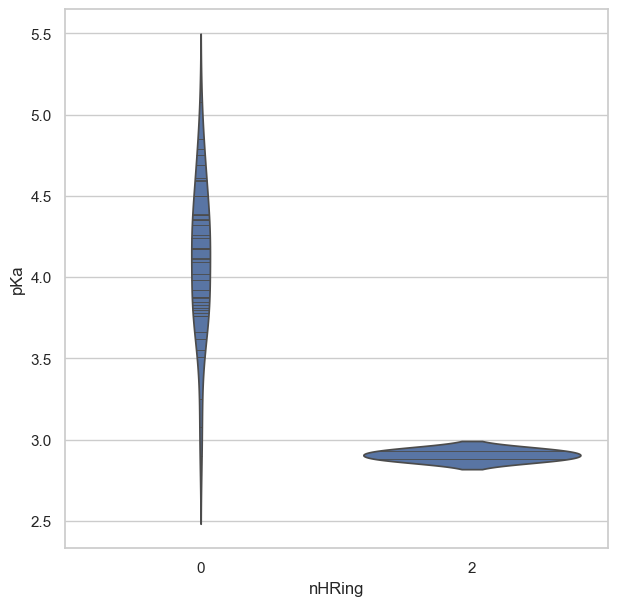

Amount of feature: FPSA3: 50
R^2 score: 0.12231502164362709
{'mse': 0.0, 'mae': 0.003, 'r_score': 0.122}


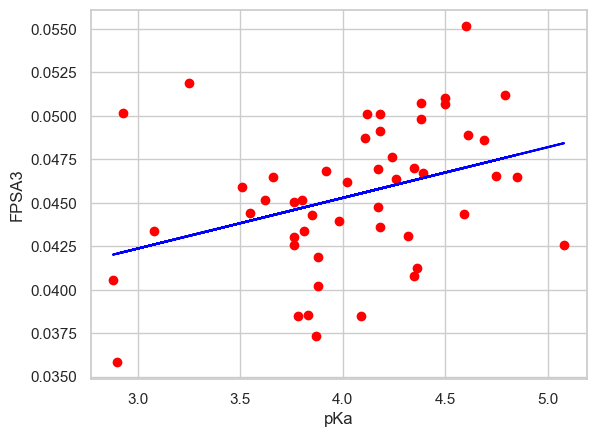

Amount of feature: nHRing: 2
Mann-Whitney U for nHRing: 95.00
P-value: 0.0213
There is a statistically significant difference between the groups


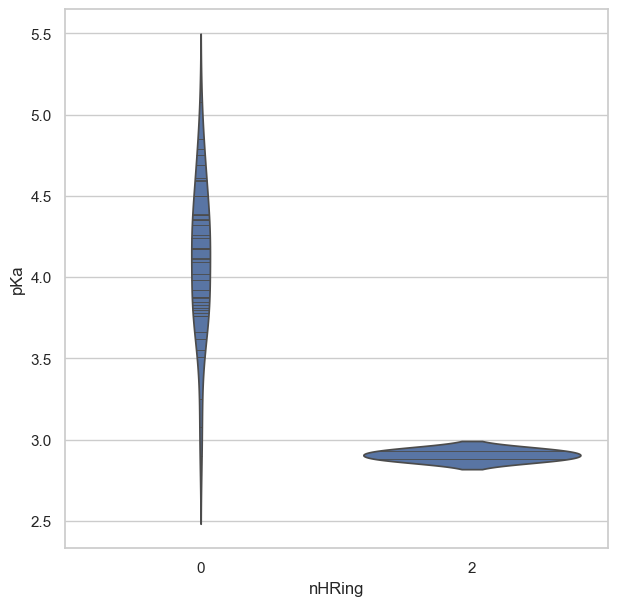

Amount of feature: mol_weight: 24
R^2 score: 0.2966680024465359
{'mse': 399.051, 'mae': 16.168, 'r_score': 0.297}


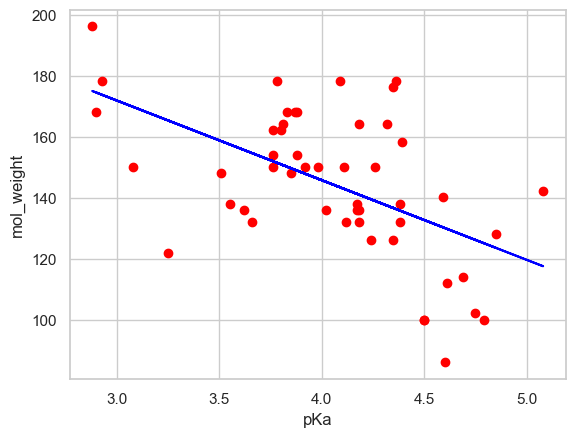

Amount of feature: PNSA5: 50
R^2 score: 0.4877343613366879
{'mse': 48.623, 'mae': 5.764, 'r_score': 0.488}


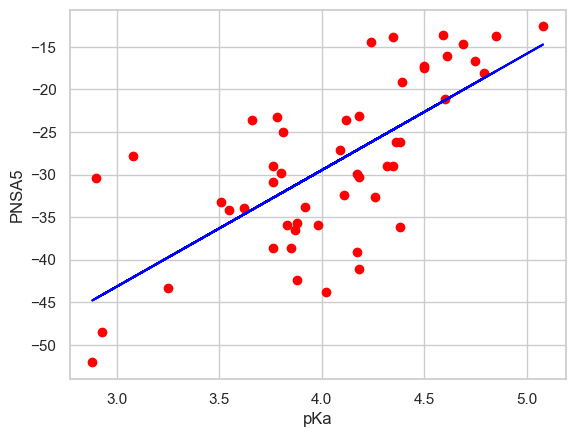

Amount of feature: distance_between_atoms_in_cycle_and_f_group: 32
R^2 score: 0.14651969102861778
{'mse': 0.474, 'mae': 0.555, 'r_score': 0.147}


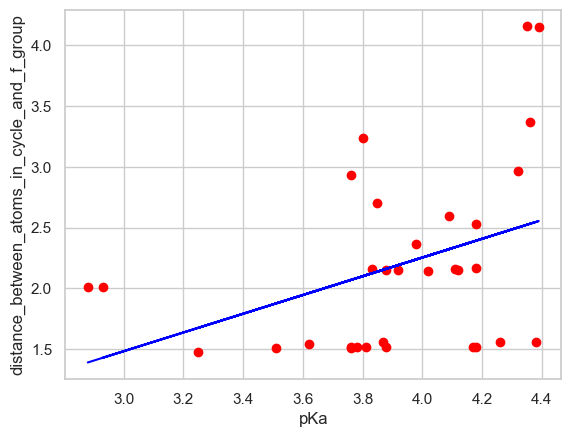

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress, mannwhitneyu, kruskal
import seaborn

seaborn.set_theme(style = 'whitegrid') 


def complete_mannwhitneyu_test(values1, values2, feature_name):
    result = mannwhitneyu(values1, values2, alternative='two-sided')

    print(f"Mann-Whitney U for {feature_name}: {result.statistic:.2f}")
    print(f"P-value: {result.pvalue:.4f}")

    if result.pvalue < 0.05:
        print("There is a statistically significant difference between the groups")
    else:
        print("There isn't any statistically significant difference between the groups")

    return result.pvalue


def complete_kruskal_test(groups, feature_name):
    result = kruskal(*groups)

    print(f"Kruskal for {feature_name}: {result.statistic:.2f}")
    print(f"P-value: {result.pvalue:.4f}")

    if result.pvalue < 0.05:
        print("There is a statistically significant difference between the groups")
    else:
        print("There isn't any statistically significant difference between the groups")
    
    return result.pvalue


# feature_names = df_features.columns
feature_names = ['FPSA3',
 'PNSA5',
 'PPSA5',
 'dipole_moment',
 'distance_between_atoms_in_cycle_and_f_group',
 'f_freedom',
 'f_to_fg',
 'mol_weight',
 'nF',
 'nHRing',
 'nO']
# feature_names.append('pKa')
remained_features = set()

for factor_index in range(n_factors):
    factor_representation = fa.loadings_[:, factor_index]

    for feature_index in range(len(feature_names)):
        if abs(factor_representation[feature_index]) < 0.5:
            continue

        if feature_names[feature_index] == 'pKa':
            continue
        
        feature_name = feature_names[feature_index]
        # print(f"Factor: {factor_index}, feature: {feature_names[feature_index]}, representation: {factor_representation[feature_index]}, logP repsentation: {factor_representation[-1]}")

        _x = list(df_features['pKa'])
        _y = list(df_features[feature_names[feature_index]])
        x, y = [], []
        for index in range(len(_x)):
            if _y[index] == 0 and ("angle" in feature_names[feature_index] or "distance" in feature_names[feature_index]):
                continue
            else:
                x.append(_x[index])
                y.append(_y[index])


        print(f"Amount of feature: {feature_name}: {len(set(y))}")
        if len(set(y)) > 15:
            slope, intercept, r, p, se = linregress(x, y)
            y_line = [slope * xi + intercept for xi in x]

            r_2 = pow(r, 2)
            if r_2 > 0.1:
                remained_features.add(feature_name)
                
            print(f"R^2 score: {r_2}")
            print(calculate_metrics(y, y_line))

            plt.scatter(x=x, y=y, color="red")
            plt.plot(x, y_line, color="blue")
            plt.xlabel('pKa')
            plt.ylabel(feature_names[feature_index])
            plt.show()
            # break

        else:

            df_dict = {}
            vals, names, xs = [],[],[]
            for i, unique_values in enumerate(sorted(set(y))):
                values = df_features[df_features[feature_name] == unique_values]['pKa']
                vals.append(values)
                names.append(f"{feature_name}: {i}")
                df_dict[f"{feature_name}: {unique_values}"] = values
                xs.append(np.random.normal(unique_values, 0.08, values.shape[0])) 

            if len(set(y)) == 2:
                values1 = df_features[df_features[feature_name] == list(set(y))[0]]['pKa']
                values2 = df_features[df_features[feature_name] == list(set(y))[1]]['pKa']
                pvalue = complete_mannwhitneyu_test(values1=values1, 
                                           values2=values2, 
                                           feature_name=feature_name)
            else:
                pvalue = complete_kruskal_test(groups=vals, 
                                      feature_name=feature_name)
            
            if pvalue < 0.05:
                remained_features.add(feature_name)
            df = pd.DataFrame(df_dict)

            plt.figure(figsize=(7,7))
            seaborn.violinplot(x=feature_name, y ='pKa',
                               data = df_features,
                               inner="stick")
            plt.show()
            
                
